In [ ]:
# mount drive with files

from google.colab import drive
drive.mount('/content/drive')

# install monai

!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.6 MB/s eta 0:00:00


In [ ]:
# import libraries

import os
import shutil
import tempfile
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,

)


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet

from monai.data import (
    DataLoader,
    SmartCacheDataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# switch off warning messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set dimensions of the input images (160x160x160) and number of classes (number of labels + background)
img_dim=128
lab_num=1
class_num=lab_num+1


degree_min = -1
degree_max = 1

roi_type="face_"

split_JSON = "face-training-1-lab-v1.json"
split_JSON_run = "face-training-1-lab-v1.json"



root_dir='/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'
data_dir = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'

print(root_dir)
os.chdir(root_dir)

/content/drive/MyDrive/face-seg-project-2023/new-training-062023/


In [ ]:
# define data loaders and augmentation for training and validation

train_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),]

)


val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),

        ToTensord(keys=["image", "label"]),
    ]
)



In [ ]:
# load the files based on the lists in json

datasets = data_dir + split_JSON

datalist = load_decathlon_datalist(datasets, True, "training")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=200,
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)


Loading dataset: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


0 261-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


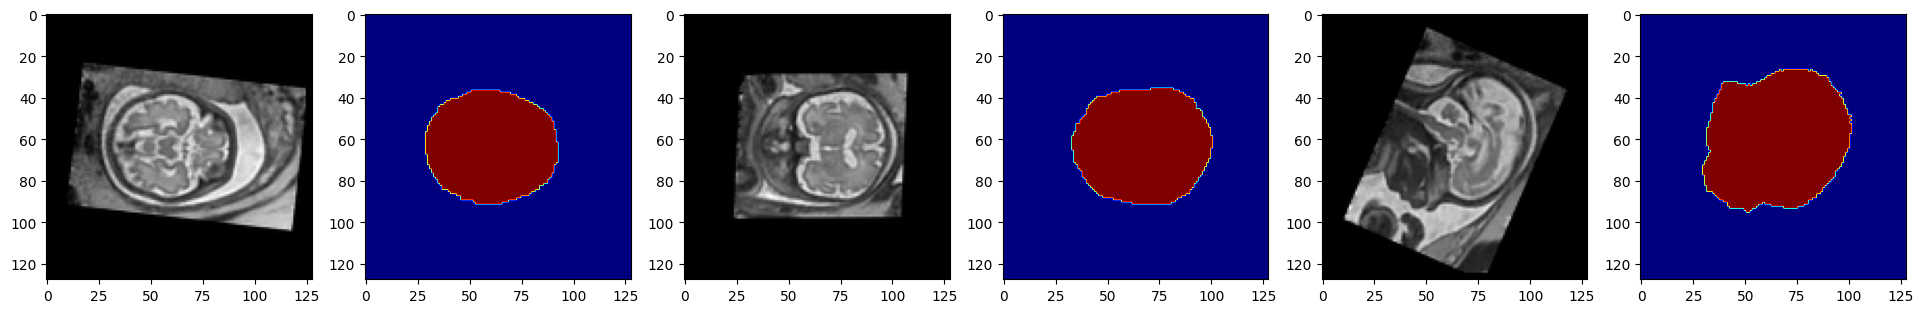

1 335-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


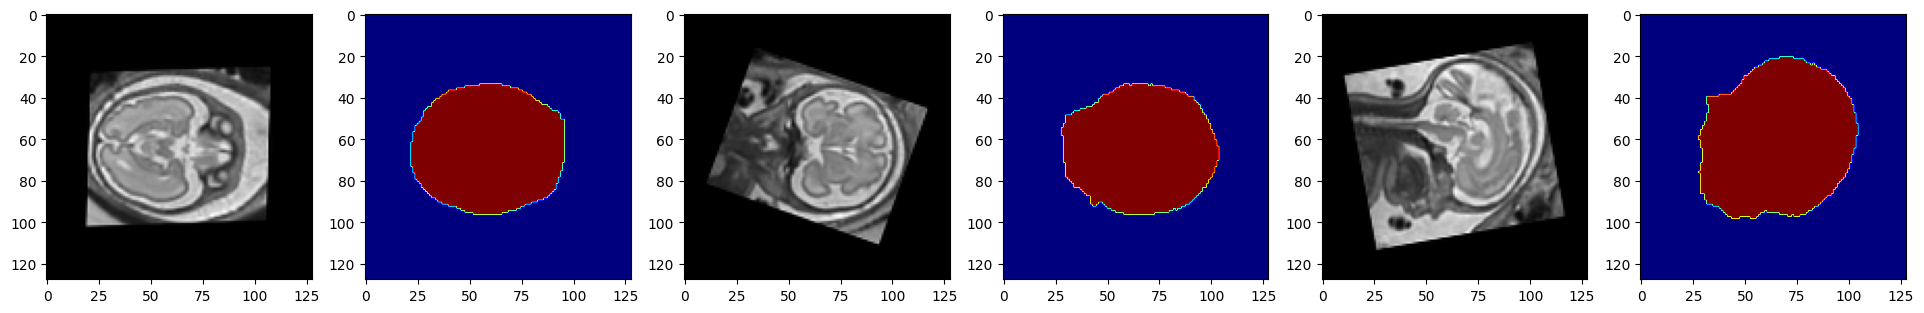

2 426-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


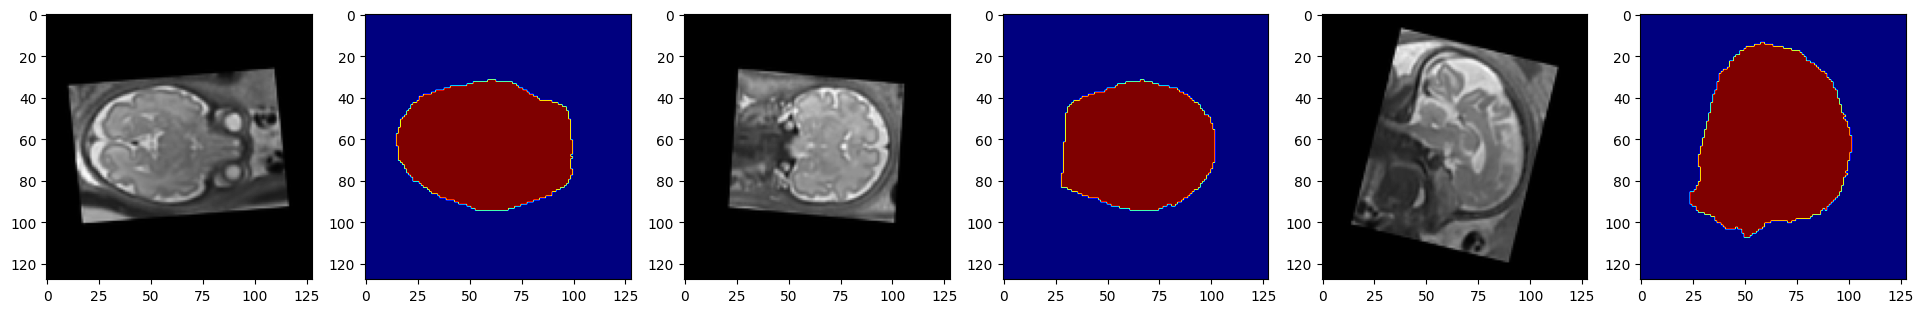

3 342-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


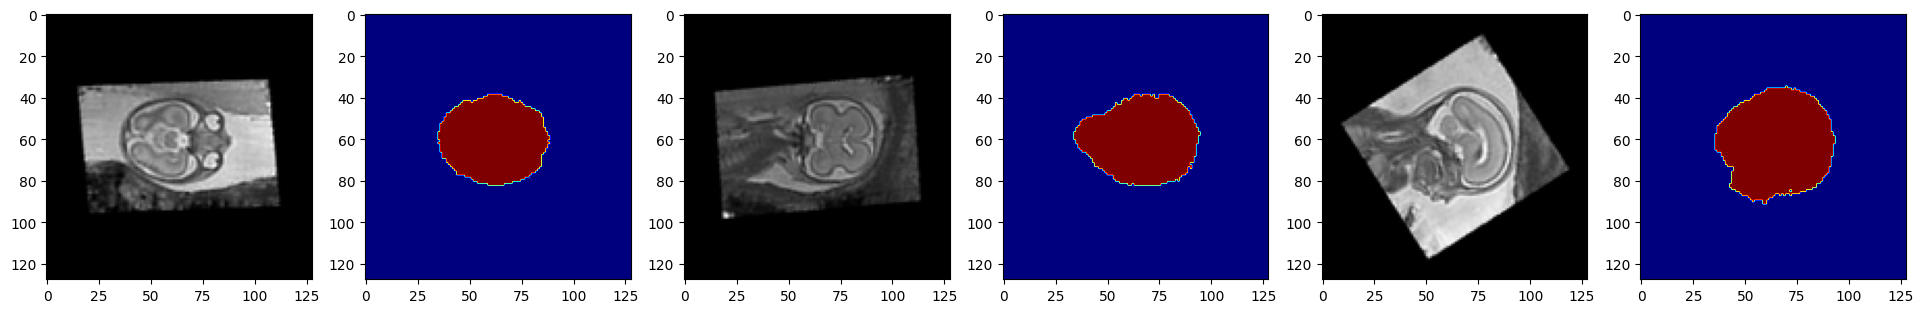

4 435-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


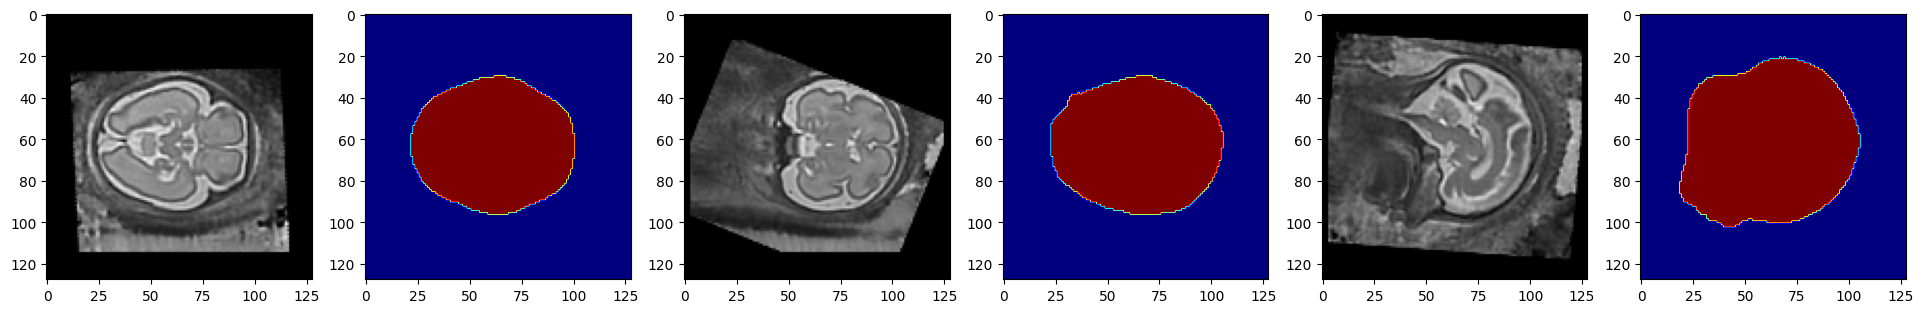

5 hist-136-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


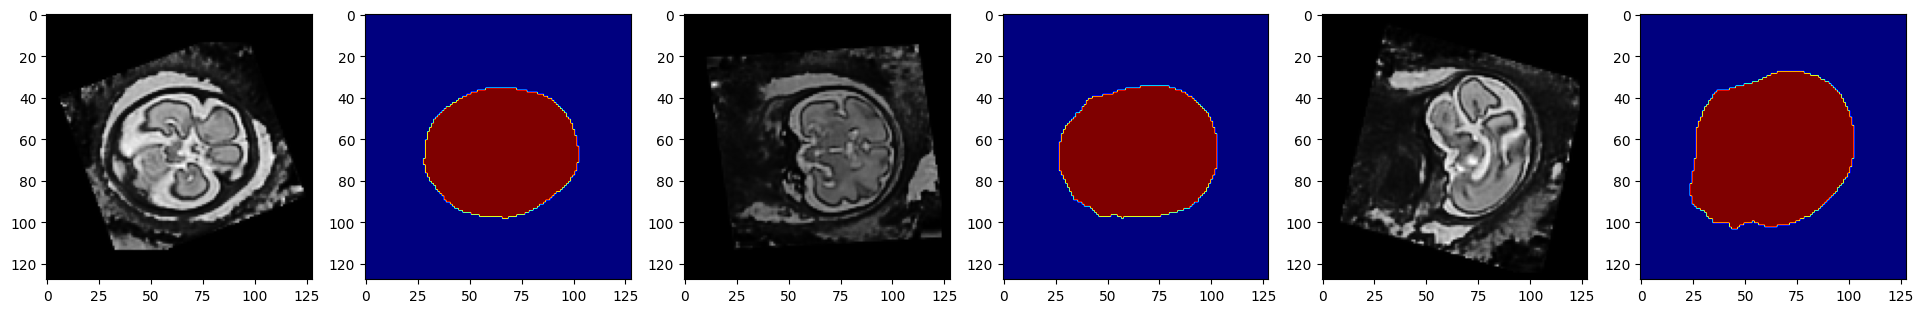

6 hist-214-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


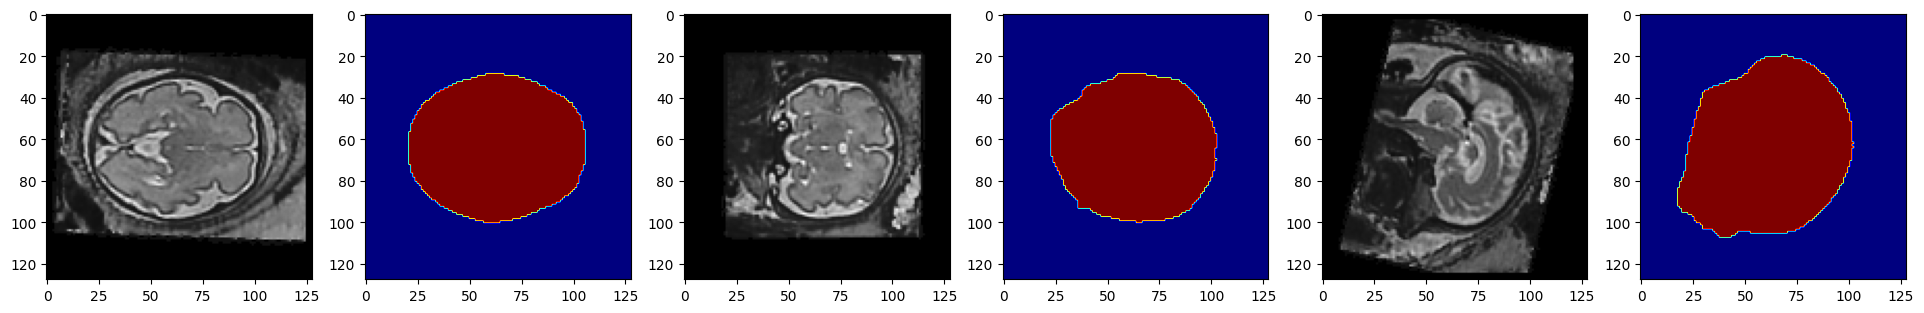

7 hist-236-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


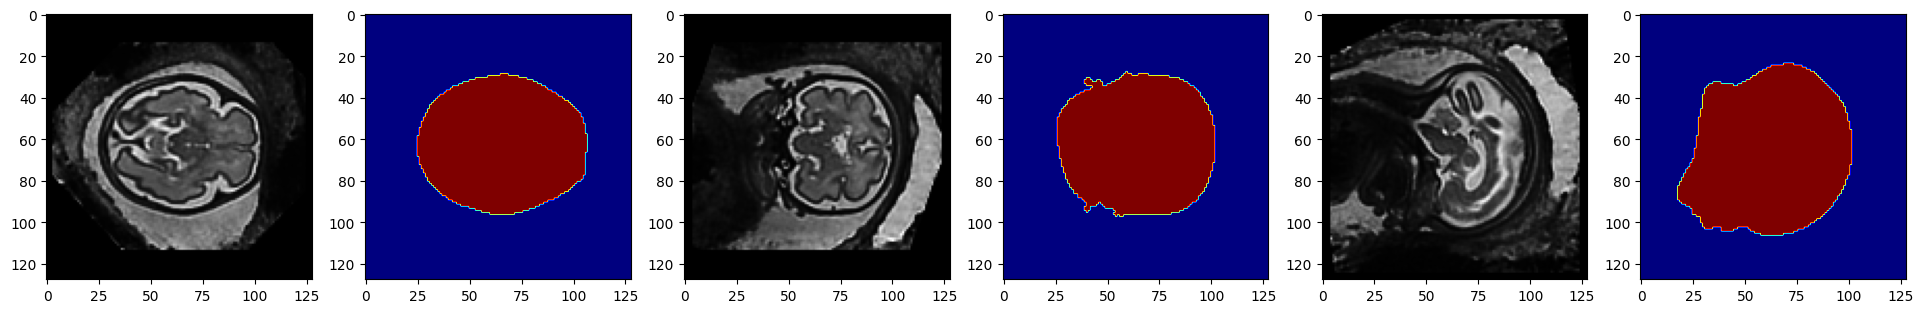

8 hist-253-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


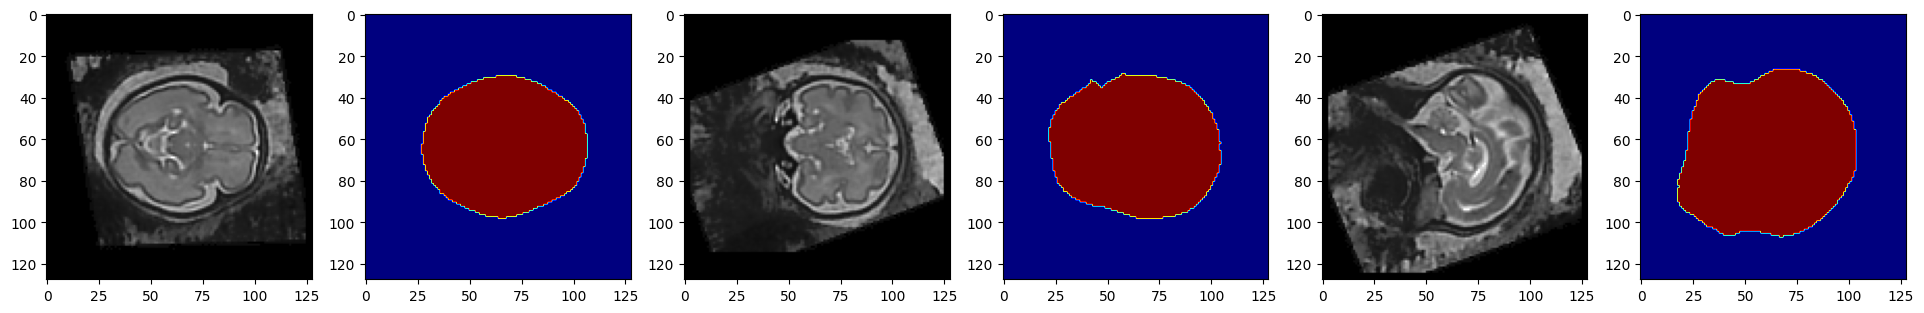

9 hist-275-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


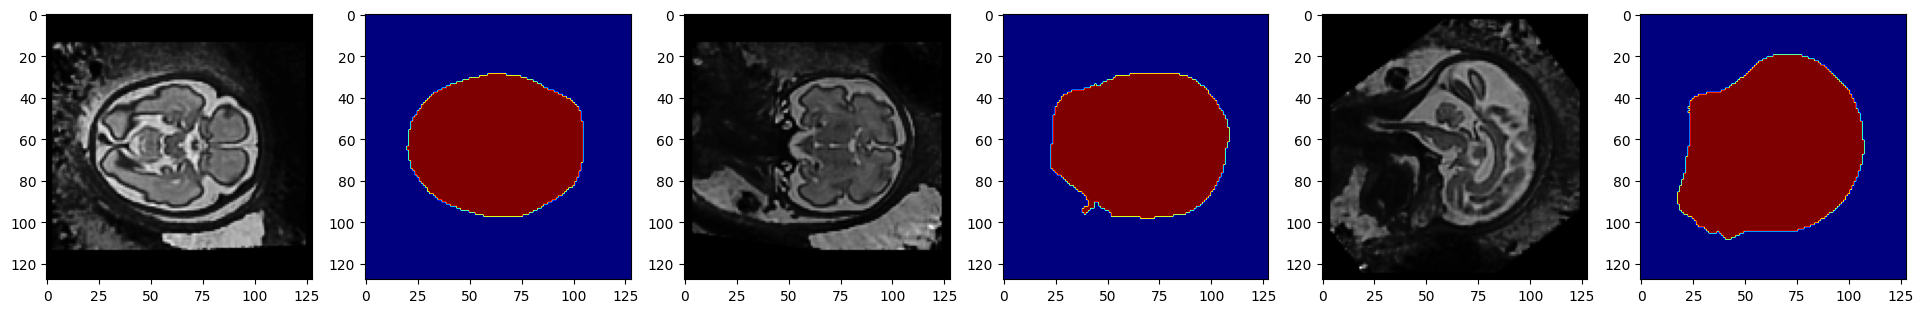

10 hist-292-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


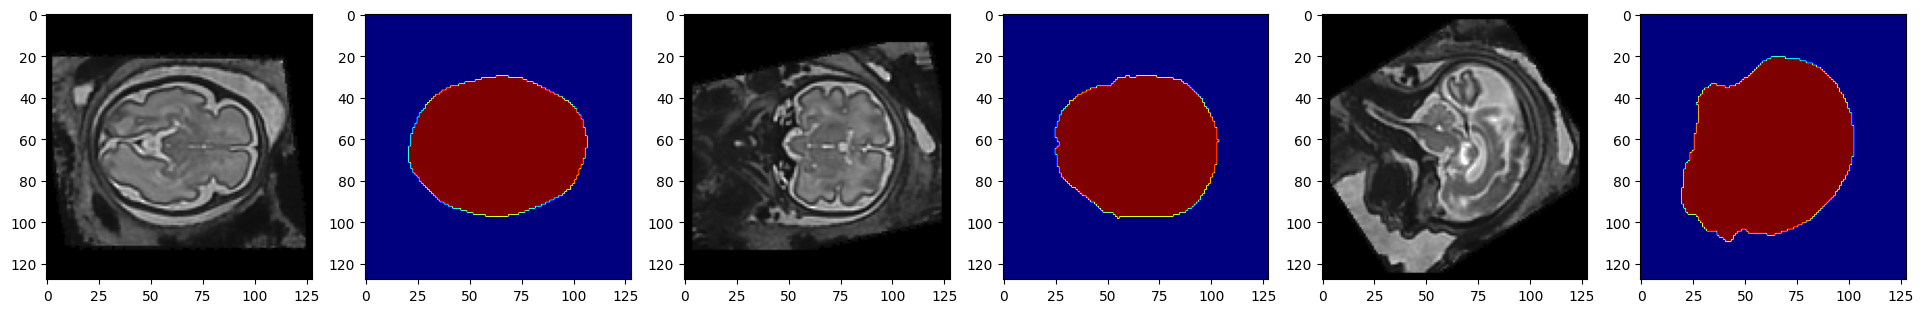

11 hist-355-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


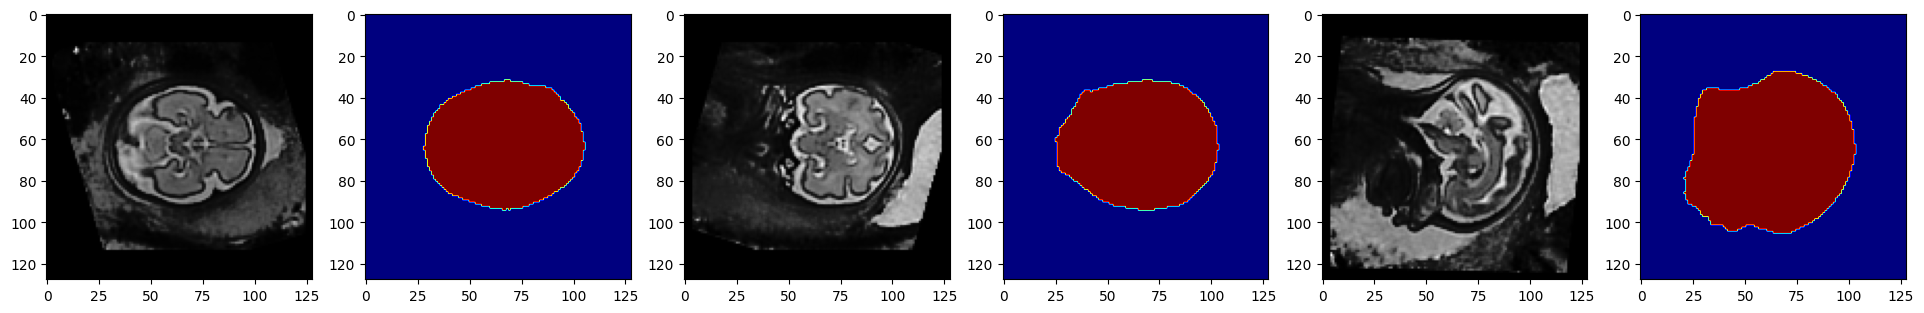

In [ ]:

s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()


In [ ]:
# define the network using MONAI

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SegResNet(spatial_dims=3,
                  init_filters=32,
                  in_channels=1,
                  out_channels=class_num,
                  dropout_prob=0.5,
                  norm='INSTANCE',
                  num_groups=32,
                  use_conv_final=True,
                  blocks_down=(1, 2, 2, 4),
                  blocks_up=(1, 1, 1),
                  upsample_mode='nontrainable').to(device)



loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement):
    model.train()
    epoch_loss = 0
    step = 0
    total_training_time = 0
    patience = 10
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    # Initialize variables for early stopping
    start_time = time.time()  # Record the start time
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        # Check if early stopping condition is met
        if epochs_without_improvement >= patience:
          print("Early stopping: Model has not improved for {} epochs.".format(patience))
          epoch_iterator.close()
          epoch_iterator_val.close()
          break

        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            #CHANGE PER MODEL
            epoch_loss_values_segresnet_no_aug.append(epoch_loss)
            #CHANGE PER MODEL
            metric_values_segresnet_no_aug.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                epochs_without_improvement = 0 # Reset patience counter
                print("Patience Counter has Been Reset")
                #CHANGE PER MODEL
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"segresnet_no_aug_best_metric_model.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("Epochs Without Improvement:{}".format(epochs_without_improvement))

            else:
              epochs_without_improvement += 1
              #CHANGE PER MODEL
              torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"segresnet_no_aug_latest_metric_model.pth")))
              print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
              print("+1 Added to Patience Counter")
              print("Epochs Without Improvement:{}".format(epochs_without_improvement))



        global_step += 1

    # Training loop has completed, calculate the total training time
    end_time = time.time()
    epoch_iterator.close()

    total_training_time += end_time - start_time
    total_training_time_minutes = total_training_time / 60
    print(f"\nTotal Training Time: {total_training_time_minutes:.2f} minutes")
    print(f"Global step: {global_step}, Eval num: {eval_num}, Max iterations: {max_iterations}")
    return global_step, dice_val_best, global_step_best, epochs_without_improvement





In [ ]:
max_iterations = 30000
eval_num = 200
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epochs_without_improvement = 0
epoch_loss_values_segresnet_no_aug = []
metric_values_segresnet_no_aug = []

In [ ]:
# run training

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
        global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement
    )

Training (81 / 30000 Steps) (loss=0.51833): 100%|██████████| 82/82 [02:55<00:00,  2.15s/it]



Total Training Time: 2.93 minutes
Global step: 82, Eval num: 200, Max iterations: 30000


Training (163 / 30000 Steps) (loss=0.48103): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 164, Eval num: 200, Max iterations: 30000


Training (200 / 30000 Steps) (loss=0.43185):  45%|████▌     | 37/82 [01:07<02:36,  3.48s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9287054389715195 Current Avg. Dice: 0.9287054389715195
Epochs Without Improvement:0


Training (245 / 30000 Steps) (loss=0.36427): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 246, Eval num: 200, Max iterations: 30000


Training (327 / 30000 Steps) (loss=0.51938): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 328, Eval num: 200, Max iterations: 30000


Training (400 / 30000 Steps) (loss=0.33708):  89%|████████▉ | 73/82 [02:08<00:31,  3.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9287054389715195 Current Avg. Dice: 0.9145890474319458
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (409 / 30000 Steps) (loss=0.29144): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 410, Eval num: 200, Max iterations: 30000


Training (491 / 30000 Steps) (loss=0.30471): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 492, Eval num: 200, Max iterations: 30000


Training (573 / 30000 Steps) (loss=0.30231): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 574, Eval num: 200, Max iterations: 30000


Training (600 / 30000 Steps) (loss=0.31099):  33%|███▎      | 27/82 [00:51<03:15,  3.55s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9473864982525507 Current Avg. Dice: 0.9473864982525507
Epochs Without Improvement:0


Training (655 / 30000 Steps) (loss=0.40415): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 656, Eval num: 200, Max iterations: 30000


Training (737 / 30000 Steps) (loss=0.20002): 100%|██████████| 82/82 [02:16<00:00,  1.66s/it]



Total Training Time: 2.27 minutes
Global step: 738, Eval num: 200, Max iterations: 30000


Training (800 / 30000 Steps) (loss=0.20937):  77%|███████▋  | 63/82 [01:51<01:05,  3.44s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9474537918965021 Current Avg. Dice: 0.9474537918965021
Epochs Without Improvement:0


Training (819 / 30000 Steps) (loss=0.19730): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 820, Eval num: 200, Max iterations: 30000


Training (901 / 30000 Steps) (loss=0.15207): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 902, Eval num: 200, Max iterations: 30000


Training (983 / 30000 Steps) (loss=0.15120): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 984, Eval num: 200, Max iterations: 30000


Validate (984 / 10 Steps) (dice=0.97734): 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Patience Counter has Been Reset


Training (1000 / 30000 Steps) (loss=0.18255):  21%|██        | 17/82 [00:34<03:41,  3.41s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9728392114241918 Current Avg. Dice: 0.9728392114241918
Epochs Without Improvement:0


Training (1065 / 30000 Steps) (loss=0.14373): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.36 minutes
Global step: 1066, Eval num: 200, Max iterations: 30000


Training (1147 / 30000 Steps) (loss=0.13076): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 1148, Eval num: 200, Max iterations: 30000


Validate (1148 / 10 Steps) (dice=0.98010): 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Patience Counter has Been Reset


Training (1200 / 30000 Steps) (loss=0.10502):  65%|██████▍   | 53/82 [01:34<01:41,  3.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9769372741381327 Current Avg. Dice: 0.9769372741381327
Epochs Without Improvement:0


Training (1229 / 30000 Steps) (loss=0.15910): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 1230, Eval num: 200, Max iterations: 30000


Training (1311 / 30000 Steps) (loss=0.10474): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 1312, Eval num: 200, Max iterations: 30000


Training (1393 / 30000 Steps) (loss=0.17778): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 1394, Eval num: 200, Max iterations: 30000


Training (1400 / 30000 Steps) (loss=0.09257):   9%|▊         | 7/82 [00:18<04:34,  3.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9769372741381327 Current Avg. Dice: 0.9628715018431345
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (1475 / 30000 Steps) (loss=0.10405): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 1476, Eval num: 200, Max iterations: 30000


Training (1557 / 30000 Steps) (loss=0.10948): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 1558, Eval num: 200, Max iterations: 30000


Training (1600 / 30000 Steps) (loss=0.08935):  52%|█████▏    | 43/82 [01:17<02:12,  3.40s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9795283377170563 Current Avg. Dice: 0.9795283377170563
Epochs Without Improvement:0


Training (1639 / 30000 Steps) (loss=0.08714): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.36 minutes
Global step: 1640, Eval num: 200, Max iterations: 30000


Training (1721 / 30000 Steps) (loss=0.08326): 100%|██████████| 82/82 [02:16<00:00,  1.66s/it]



Total Training Time: 2.27 minutes
Global step: 1722, Eval num: 200, Max iterations: 30000


Training (1800 / 30000 Steps) (loss=0.06599):  96%|█████████▋| 79/82 [02:17<00:10,  3.47s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.980170950293541 Current Avg. Dice: 0.980170950293541
Epochs Without Improvement:0


Training (1803 / 30000 Steps) (loss=0.05741): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 1804, Eval num: 200, Max iterations: 30000


Training (1885 / 30000 Steps) (loss=0.07051): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 1886, Eval num: 200, Max iterations: 30000


Training (1967 / 30000 Steps) (loss=0.09362): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 1968, Eval num: 200, Max iterations: 30000


Training (2000 / 30000 Steps) (loss=0.06216):  40%|████      | 33/82 [01:00<02:46,  3.41s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.980170950293541 Current Avg. Dice: 0.9773128728071848
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2049 / 30000 Steps) (loss=0.12106): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.36 minutes
Global step: 2050, Eval num: 200, Max iterations: 30000


Training (2131 / 30000 Steps) (loss=0.17286): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 2132, Eval num: 200, Max iterations: 30000


Training (2200 / 30000 Steps) (loss=0.04729):  84%|████████▍ | 69/82 [02:01<00:45,  3.50s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.981162761648496 Current Avg. Dice: 0.981162761648496
Epochs Without Improvement:0


Training (2213 / 30000 Steps) (loss=0.08036): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 2214, Eval num: 200, Max iterations: 30000


Training (2295 / 30000 Steps) (loss=0.05419): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 2296, Eval num: 200, Max iterations: 30000


Training (2377 / 30000 Steps) (loss=0.08529): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 2378, Eval num: 200, Max iterations: 30000


Validate (2378 / 10 Steps) (dice=0.98563): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Patience Counter has Been Reset


Training (2400 / 30000 Steps) (loss=0.04914):  28%|██▊       | 23/82 [00:44<03:23,  3.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9813186476627985 Current Avg. Dice: 0.9813186476627985
Epochs Without Improvement:0


Training (2459 / 30000 Steps) (loss=0.04837): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 2460, Eval num: 200, Max iterations: 30000


Training (2541 / 30000 Steps) (loss=0.04056): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 2542, Eval num: 200, Max iterations: 30000


Validate (2542 / 10 Steps) (dice=0.98652): 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Patience Counter has Been Reset


Training (2600 / 30000 Steps) (loss=0.03787):  72%|███████▏  | 59/82 [01:44<01:21,  3.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9818412115176519 Current Avg. Dice: 0.9818412115176519
Epochs Without Improvement:0


Training (2623 / 30000 Steps) (loss=0.03433): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 2624, Eval num: 200, Max iterations: 30000


Training (2705 / 30000 Steps) (loss=0.04129): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 2706, Eval num: 200, Max iterations: 30000


Training (2787 / 30000 Steps) (loss=0.03183): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 2788, Eval num: 200, Max iterations: 30000


Validate (2788 / 10 Steps) (dice=0.98673): 100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Patience Counter has Been Reset


Training (2800 / 30000 Steps) (loss=0.02996):  16%|█▌        | 13/82 [00:28<04:03,  3.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9827026575803757 Current Avg. Dice: 0.9827026575803757
Epochs Without Improvement:0


Training (2869 / 30000 Steps) (loss=0.02726): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 2870, Eval num: 200, Max iterations: 30000


Training (2951 / 30000 Steps) (loss=0.03900): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 2952, Eval num: 200, Max iterations: 30000


Training (3000 / 30000 Steps) (loss=0.03186):  60%|█████▉    | 49/82 [01:27<01:55,  3.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9827026575803757 Current Avg. Dice: 0.9819550464550654
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (3033 / 30000 Steps) (loss=0.03379): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 3034, Eval num: 200, Max iterations: 30000


Training (3115 / 30000 Steps) (loss=0.03723): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 3116, Eval num: 200, Max iterations: 30000


Training (3197 / 30000 Steps) (loss=0.05842): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 3198, Eval num: 200, Max iterations: 30000


Training (3200 / 30000 Steps) (loss=0.02299):   4%|▎         | 3/82 [00:11<05:53,  4.47s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9831940531730652 Current Avg. Dice: 0.9831940531730652
Epochs Without Improvement:0


Training (3279 / 30000 Steps) (loss=0.04778): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.36 minutes
Global step: 3280, Eval num: 200, Max iterations: 30000


Training (3361 / 30000 Steps) (loss=0.02669): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 3362, Eval num: 200, Max iterations: 30000


Training (3400 / 30000 Steps) (loss=0.02665):  48%|████▊     | 39/82 [01:11<02:29,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9831940531730652 Current Avg. Dice: 0.982112780213356
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (3443 / 30000 Steps) (loss=0.02695): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 3444, Eval num: 200, Max iterations: 30000


Training (3525 / 30000 Steps) (loss=0.06310): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 3526, Eval num: 200, Max iterations: 30000


Training (3600 / 30000 Steps) (loss=0.05317):  91%|█████████▏| 75/82 [02:11<00:24,  3.49s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9832873940467834 Current Avg. Dice: 0.9832873940467834
Epochs Without Improvement:0


Training (3607 / 30000 Steps) (loss=0.02808): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 3608, Eval num: 200, Max iterations: 30000


Training (3689 / 30000 Steps) (loss=0.05963): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 3690, Eval num: 200, Max iterations: 30000


Training (3771 / 30000 Steps) (loss=0.02631): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 3772, Eval num: 200, Max iterations: 30000


Validate (3772 / 10 Steps) (dice=0.98778): 100%|██████████| 12/12 [00:05<00:00,  2.07it/s]


Patience Counter has Been Reset


Training (3800 / 30000 Steps) (loss=0.02739):  35%|███▌      | 29/82 [00:54<03:03,  3.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9836770792802175 Current Avg. Dice: 0.9836770792802175
Epochs Without Improvement:0


Training (3853 / 30000 Steps) (loss=0.04251): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 3854, Eval num: 200, Max iterations: 30000


Training (3935 / 30000 Steps) (loss=0.05756): 100%|██████████| 82/82 [02:17<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 3936, Eval num: 200, Max iterations: 30000


Training (4000 / 30000 Steps) (loss=0.04692):  79%|███████▉  | 65/82 [01:54<00:58,  3.47s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9842473715543747 Current Avg. Dice: 0.9842473715543747
Epochs Without Improvement:0


Training (4017 / 30000 Steps) (loss=0.02173): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 4018, Eval num: 200, Max iterations: 30000


Training (4099 / 30000 Steps) (loss=0.02168): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 4100, Eval num: 200, Max iterations: 30000


Training (4181 / 30000 Steps) (loss=0.02105): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 4182, Eval num: 200, Max iterations: 30000


Training (4200 / 30000 Steps) (loss=0.02531):  23%|██▎       | 19/82 [00:37<03:39,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842473715543747 Current Avg. Dice: 0.9838155061006546
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4263 / 30000 Steps) (loss=0.06084): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 4264, Eval num: 200, Max iterations: 30000


Training (4345 / 30000 Steps) (loss=0.01697): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 4346, Eval num: 200, Max iterations: 30000


Training (4400 / 30000 Steps) (loss=0.02133):  67%|██████▋   | 55/82 [01:37<01:31,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842473715543747 Current Avg. Dice: 0.983865812420845
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (4427 / 30000 Steps) (loss=0.01679): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.36 minutes
Global step: 4428, Eval num: 200, Max iterations: 30000


Training (4509 / 30000 Steps) (loss=0.03411): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 4510, Eval num: 200, Max iterations: 30000


Training (4591 / 30000 Steps) (loss=0.01737): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 4592, Eval num: 200, Max iterations: 30000


Training (4600 / 30000 Steps) (loss=0.03334):  11%|█         | 9/82 [00:21<04:22,  3.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842473715543747 Current Avg. Dice: 0.9792704631884893
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (4673 / 30000 Steps) (loss=0.01621): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.38 minutes
Global step: 4674, Eval num: 200, Max iterations: 30000


Training (4755 / 30000 Steps) (loss=0.03157): 100%|██████████| 82/82 [02:16<00:00,  1.66s/it]



Total Training Time: 2.28 minutes
Global step: 4756, Eval num: 200, Max iterations: 30000


Training (4800 / 30000 Steps) (loss=0.01761):  55%|█████▍    | 45/82 [01:21<02:10,  3.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842473715543747 Current Avg. Dice: 0.9842444608608881
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (4837 / 30000 Steps) (loss=0.01466): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 4838, Eval num: 200, Max iterations: 30000


Training (4919 / 30000 Steps) (loss=0.01470): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 4920, Eval num: 200, Max iterations: 30000


Training (5000 / 30000 Steps) (loss=0.01754):  99%|█████████▉| 81/82 [02:20<00:03,  3.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9842473715543747 Current Avg. Dice: 0.9838894605636597
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (5001 / 30000 Steps) (loss=0.01531): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 5002, Eval num: 200, Max iterations: 30000


Training (5083 / 30000 Steps) (loss=0.01328): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 5084, Eval num: 200, Max iterations: 30000


Training (5165 / 30000 Steps) (loss=0.04823): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 5166, Eval num: 200, Max iterations: 30000


Training (5200 / 30000 Steps) (loss=0.01308):  43%|████▎     | 35/82 [01:04<02:41,  3.43s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9851803531249365 Current Avg. Dice: 0.9851803531249365
Epochs Without Improvement:0


Training (5247 / 30000 Steps) (loss=0.01170): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.36 minutes
Global step: 5248, Eval num: 200, Max iterations: 30000


Training (5329 / 30000 Steps) (loss=0.03257): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 5330, Eval num: 200, Max iterations: 30000


Training (5400 / 30000 Steps) (loss=0.03539):  87%|████████▋ | 71/82 [02:04<00:38,  3.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851803531249365 Current Avg. Dice: 0.9822258104880651
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (5411 / 30000 Steps) (loss=0.01521): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 5412, Eval num: 200, Max iterations: 30000


Training (5493 / 30000 Steps) (loss=0.01224): 100%|██████████| 82/82 [02:17<00:00,  1.67s/it]



Total Training Time: 2.29 minutes
Global step: 5494, Eval num: 200, Max iterations: 30000


Training (5575 / 30000 Steps) (loss=0.02221): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 5576, Eval num: 200, Max iterations: 30000


Training (5600 / 30000 Steps) (loss=0.03465):  30%|███       | 25/82 [00:48<03:19,  3.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851803531249365 Current Avg. Dice: 0.9842091699441274
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (5657 / 30000 Steps) (loss=0.01353): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 5658, Eval num: 200, Max iterations: 30000


Training (5739 / 30000 Steps) (loss=0.01339): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 5740, Eval num: 200, Max iterations: 30000


Training (5800 / 30000 Steps) (loss=0.00967):  74%|███████▍  | 61/82 [01:47<01:11,  3.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851803531249365 Current Avg. Dice: 0.9839726636807123
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (5821 / 30000 Steps) (loss=0.01280): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 5822, Eval num: 200, Max iterations: 30000


Training (5903 / 30000 Steps) (loss=0.01066): 100%|██████████| 82/82 [02:17<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 5904, Eval num: 200, Max iterations: 30000


Training (5985 / 30000 Steps) (loss=0.01369): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 5986, Eval num: 200, Max iterations: 30000


Training (6000 / 30000 Steps) (loss=0.01475):  18%|█▊        | 15/82 [00:31<03:53,  3.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851803531249365 Current Avg. Dice: 0.9845331907272339
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (6067 / 30000 Steps) (loss=0.01164): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 6068, Eval num: 200, Max iterations: 30000


Training (6149 / 30000 Steps) (loss=0.01141): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 6150, Eval num: 200, Max iterations: 30000


Training (6200 / 30000 Steps) (loss=0.00930):  62%|██████▏   | 51/82 [01:30<01:45,  3.40s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9852008918921152 Current Avg. Dice: 0.9852008918921152
Epochs Without Improvement:0


Training (6231 / 30000 Steps) (loss=0.01087): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 6232, Eval num: 200, Max iterations: 30000


Training (6313 / 30000 Steps) (loss=0.01270): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 6314, Eval num: 200, Max iterations: 30000


Training (6395 / 30000 Steps) (loss=0.00807): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 6396, Eval num: 200, Max iterations: 30000


Training (6400 / 30000 Steps) (loss=0.01380):   6%|▌         | 5/82 [00:14<04:58,  3.87s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9854323516289393
Epochs Without Improvement:0


Training (6477 / 30000 Steps) (loss=0.01618): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 6478, Eval num: 200, Max iterations: 30000


Training (6559 / 30000 Steps) (loss=0.02766): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 6560, Eval num: 200, Max iterations: 30000


Training (6600 / 30000 Steps) (loss=0.01011):  50%|█████     | 41/82 [01:14<02:22,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.984459454814593
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (6641 / 30000 Steps) (loss=0.00919): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 6642, Eval num: 200, Max iterations: 30000


Training (6723 / 30000 Steps) (loss=0.06349): 100%|██████████| 82/82 [02:16<00:00,  1.66s/it]



Total Training Time: 2.27 minutes
Global step: 6724, Eval num: 200, Max iterations: 30000


Training (6800 / 30000 Steps) (loss=0.06188):  94%|█████████▍| 77/82 [02:14<00:17,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9741879949967066
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (6805 / 30000 Steps) (loss=0.03132): 100%|██████████| 82/82 [02:22<00:00,  1.74s/it]



Total Training Time: 2.37 minutes
Global step: 6806, Eval num: 200, Max iterations: 30000


Training (6887 / 30000 Steps) (loss=0.01710): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 6888, Eval num: 200, Max iterations: 30000


Training (6969 / 30000 Steps) (loss=0.02109): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 6970, Eval num: 200, Max iterations: 30000


Training (7000 / 30000 Steps) (loss=0.01029):  38%|███▊      | 31/82 [00:57<02:56,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9845572710037231
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (7051 / 30000 Steps) (loss=0.03566): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 7052, Eval num: 200, Max iterations: 30000


Training (7133 / 30000 Steps) (loss=0.01254): 100%|██████████| 82/82 [02:17<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 7134, Eval num: 200, Max iterations: 30000


Training (7200 / 30000 Steps) (loss=0.01302):  82%|████████▏ | 67/82 [01:57<00:51,  3.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9846817006667455
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (7215 / 30000 Steps) (loss=0.02661): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 7216, Eval num: 200, Max iterations: 30000


Training (7297 / 30000 Steps) (loss=0.02630): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 7298, Eval num: 200, Max iterations: 30000


Training (7379 / 30000 Steps) (loss=0.00981): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 7380, Eval num: 200, Max iterations: 30000


Training (7400 / 30000 Steps) (loss=0.00902):  26%|██▌       | 21/82 [00:41<03:27,  3.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9850841760635376
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (7461 / 30000 Steps) (loss=0.00980): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 7462, Eval num: 200, Max iterations: 30000


Training (7543 / 30000 Steps) (loss=0.01904): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 7544, Eval num: 200, Max iterations: 30000


Training (7600 / 30000 Steps) (loss=0.01427):  70%|██████▉   | 57/82 [01:40<01:26,  3.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9850318233172098
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (7625 / 30000 Steps) (loss=0.00921): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 7626, Eval num: 200, Max iterations: 30000


Training (7707 / 30000 Steps) (loss=0.01077): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 7708, Eval num: 200, Max iterations: 30000


Training (7789 / 30000 Steps) (loss=0.02417): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 7790, Eval num: 200, Max iterations: 30000


Training (7800 / 30000 Steps) (loss=0.01221):  13%|█▎        | 11/82 [00:24<04:08,  3.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9846301873524984
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (7871 / 30000 Steps) (loss=0.00989): 100%|██████████| 82/82 [02:22<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 7872, Eval num: 200, Max iterations: 30000


Training (7953 / 30000 Steps) (loss=0.00783): 100%|██████████| 82/82 [02:17<00:00,  1.67s/it]



Total Training Time: 2.29 minutes
Global step: 7954, Eval num: 200, Max iterations: 30000


Training (8000 / 30000 Steps) (loss=0.01093):  57%|█████▋    | 47/82 [01:24<02:00,  3.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9851142466068268
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (8035 / 30000 Steps) (loss=0.00615): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 8036, Eval num: 200, Max iterations: 30000


Training (8117 / 30000 Steps) (loss=0.04006): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 8118, Eval num: 200, Max iterations: 30000


Training (8199 / 30000 Steps) (loss=0.01134): 100%|██████████| 82/82 [02:16<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 8200, Eval num: 200, Max iterations: 30000


Training (8200 / 30000 Steps) (loss=0.01515):   1%|          | 1/82 [00:08<10:53,  8.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9832285145918528
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (8281 / 30000 Steps) (loss=0.01062): 100%|██████████| 82/82 [02:21<00:00,  1.73s/it]



Total Training Time: 2.37 minutes
Global step: 8282, Eval num: 200, Max iterations: 30000


Training (8363 / 30000 Steps) (loss=0.01189): 100%|██████████| 82/82 [02:17<00:00,  1.67s/it]



Total Training Time: 2.28 minutes
Global step: 8364, Eval num: 200, Max iterations: 30000


Training (8400 / 30000 Steps) (loss=0.01219):  45%|████▌     | 37/82 [01:07<02:34,  3.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9854323516289393 Current Avg. Dice: 0.9842355151971182
+1 Added to Patience Counter
Epochs Without Improvement:10


Training (8401 / 30000 Steps) (loss=0.01039):  45%|████▌     | 37/82 [01:09<01:24,  1.87s/it]


Early stopping: Model has not improved for 10 epochs.

Total Training Time: 1.16 minutes
Global step: 8401, Eval num: 200, Max iterations: 30000


Training (8401 / 30000 Steps) (loss=0.01251):   0%|          | 0/82 [00:02<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Custom TB Handler failed, unregistering
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Early stopping: Model has not improved for 10 epochs.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-10-ed525710dbfa>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 248, in wrapped
    return f(*args, **kwargs)
  File "/usr/loc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-316754e11bcc>", line 4, in <cell line: 3>
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
  File "<ipython-input-10-ed525710dbfa>", line 57, in train
    epoch_iterator_val.close()
UnboundLocalError: local variable 'epoch_iterator_val' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 1972, in wrapped
    stb = handler(self,etype,value,tb,tb_offset=tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/dask/base.py", line 79, in _clean_ipython_traceback
    stb = self.InteractiveTB.structured_traceback(
  File "/usr/local/lib/python3.10/dist-packages/IPython/c

In [ ]:
print(dice_val_best)

0.9854323516289393


In [ ]:
#CHANGE PER MODEL
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"segresnet_no_aug_best_metric_model.pth")))
#CHANGE PER MODEL
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"segresnet_no_aug_best_metric_model.pth"))))

<All keys matched successfully>

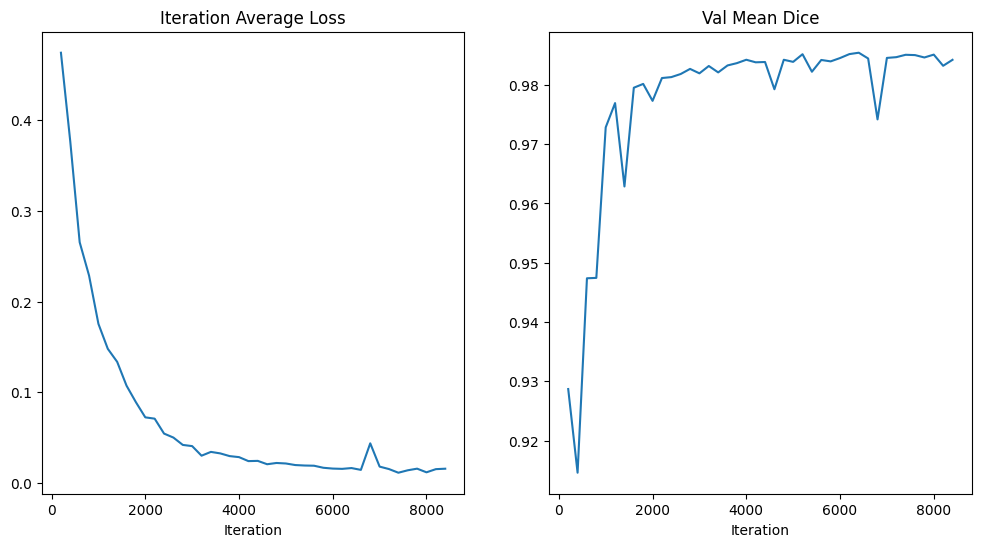

In [ ]:
# plot loss

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values_segresnet_no_aug))]
#CHANGE PER MODEL
y = epoch_loss_values_segresnet_no_aug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
#CHANGE PER MODEL
x = [eval_num * (i + 1) for i in range(len(metric_values_segresnet_no_aug))]
#CHANGE PER MODEL
y = metric_values_segresnet_no_aug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Save the metric values and epoch loss values to separate files
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "metric_values_segresnet_no_aug.npy")), np.array(metric_values_segresnet_no_aug))
#CHANGE PER MODEL
np.save(os.path.join(root_dir, (roi_type + "epoch_loss_values_segresnet_no_aug.npy")), np.array(epoch_loss_values_segresnet_no_aug))

In [ ]:
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"segresnet_no_aug_best_metric_model.pthh")))
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"segresnet_no_aug_best_metric_model.pth"))))

<All keys matched successfully>

In [ ]:
split_JSON_run = "face-training-1-lab-v1.json"


datasets_run = data_dir + split_JSON_run
val_files_run = load_decathlon_datalist(datasets_run, True, "validation")
val_ds_run = CacheDataset(
    data=val_files_run, transform=val_transforms, cache_num=300, cache_rate=1.0, num_workers=4
)
val_loader_run = DataLoader(
    val_ds_run, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 12/12 [00:00<00:00, 31.89it/s]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"segresnet_no_aug_best_metric_model.pth"))), strict=False)
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1):

0 261-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


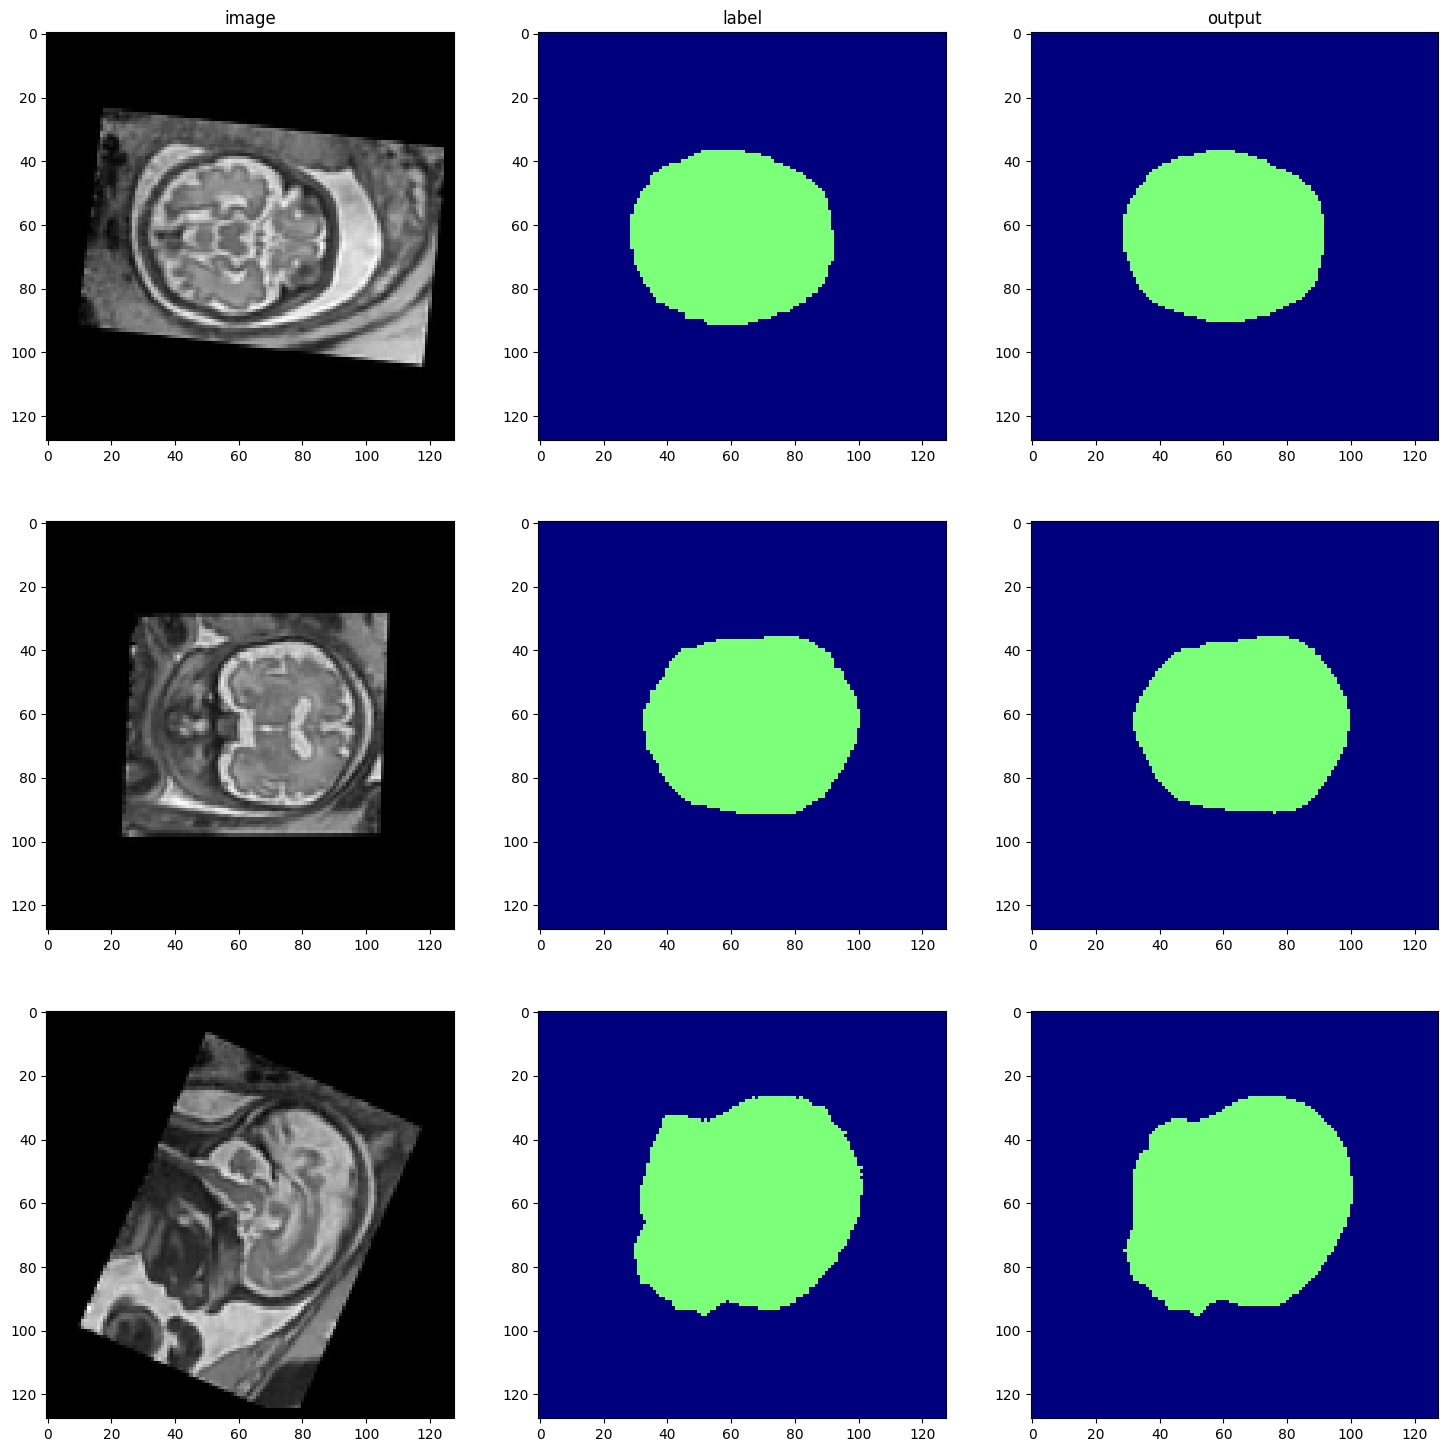

1 335-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


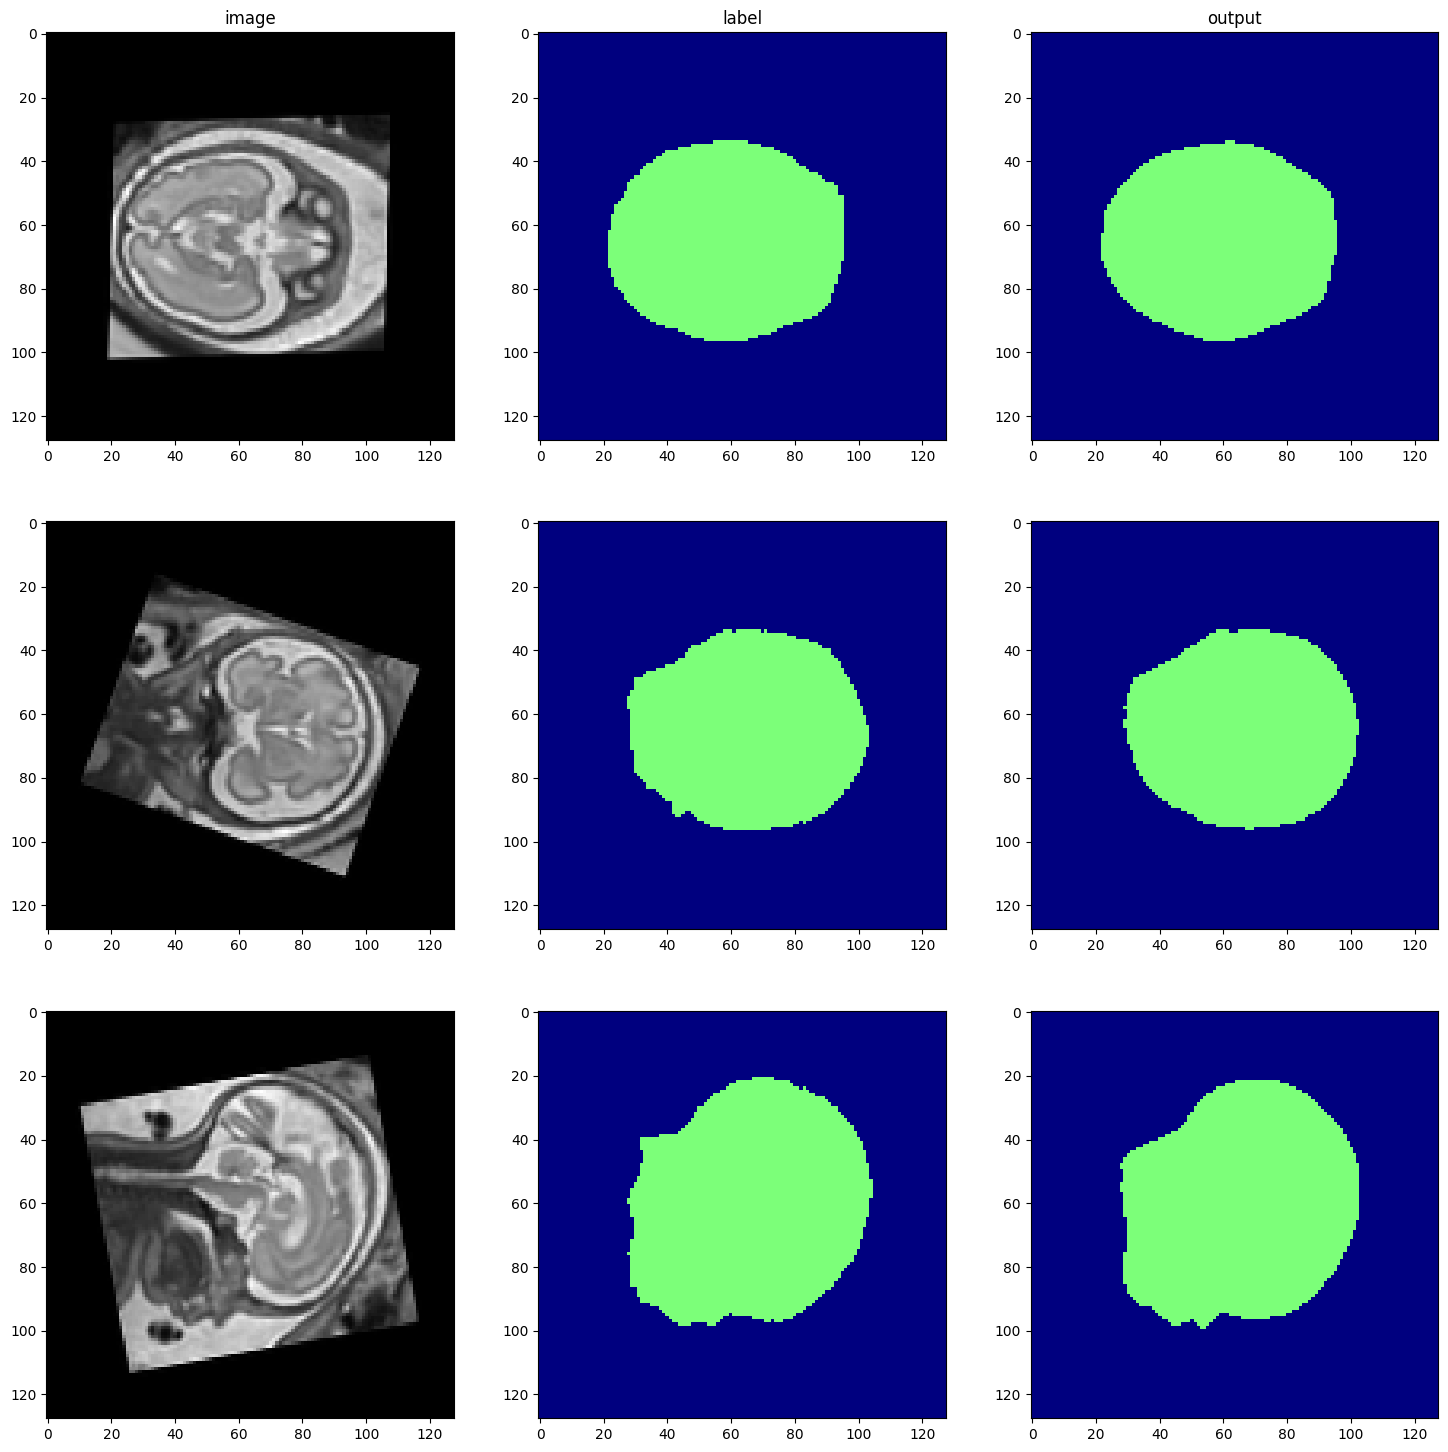

2 426-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


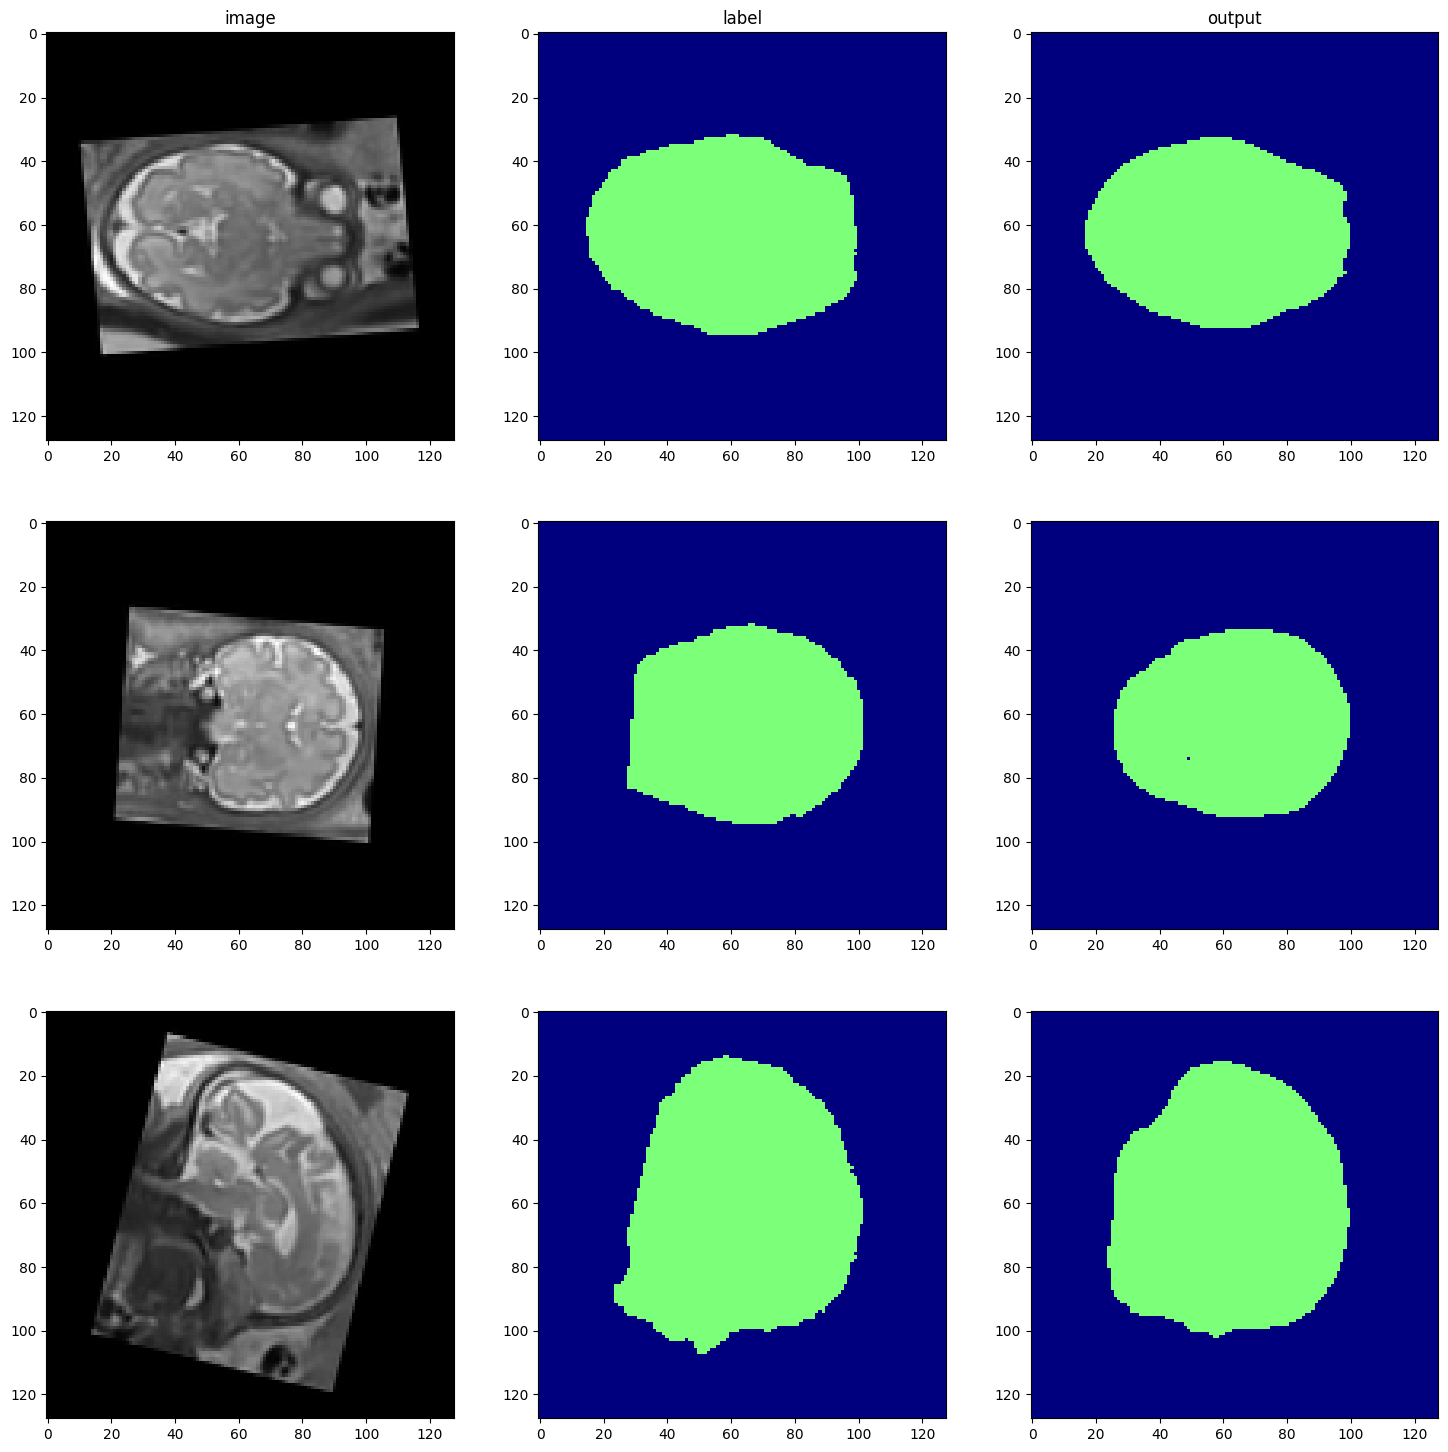

3 342-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


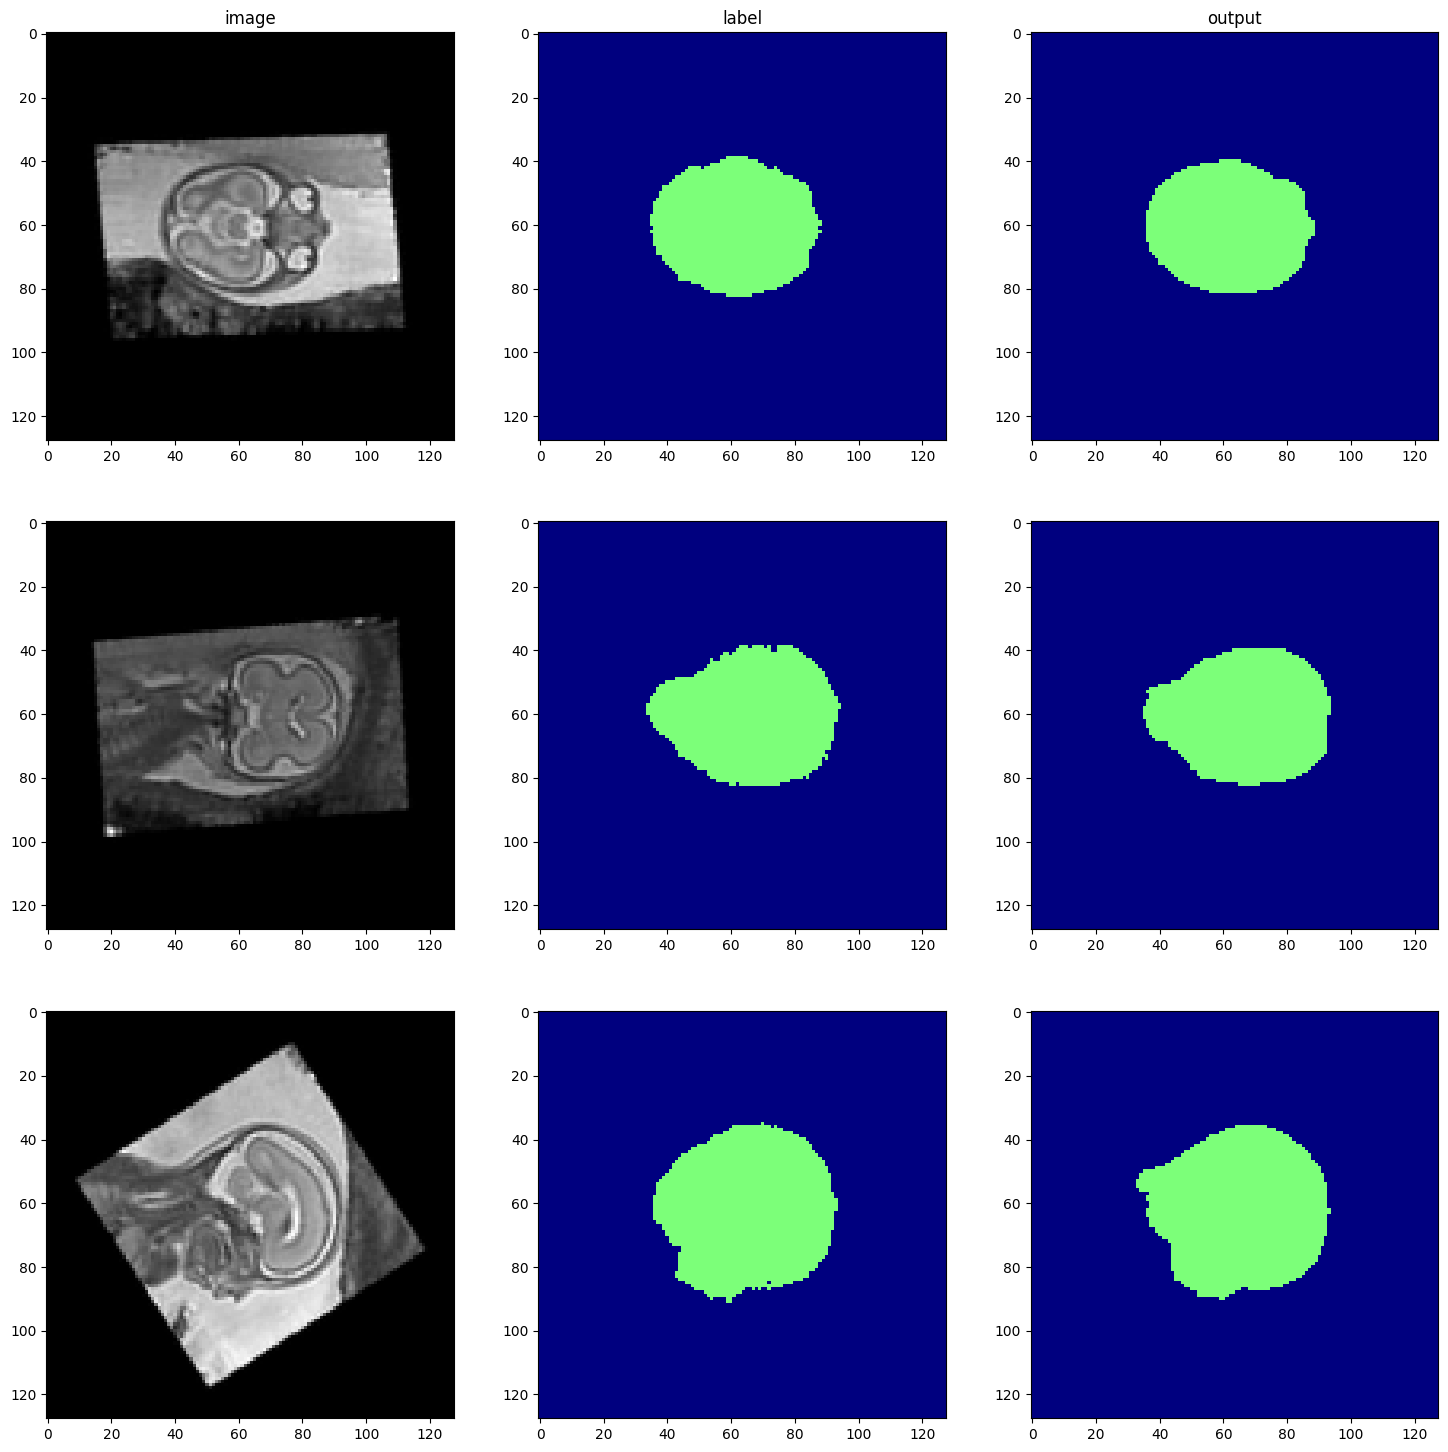

4 435-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


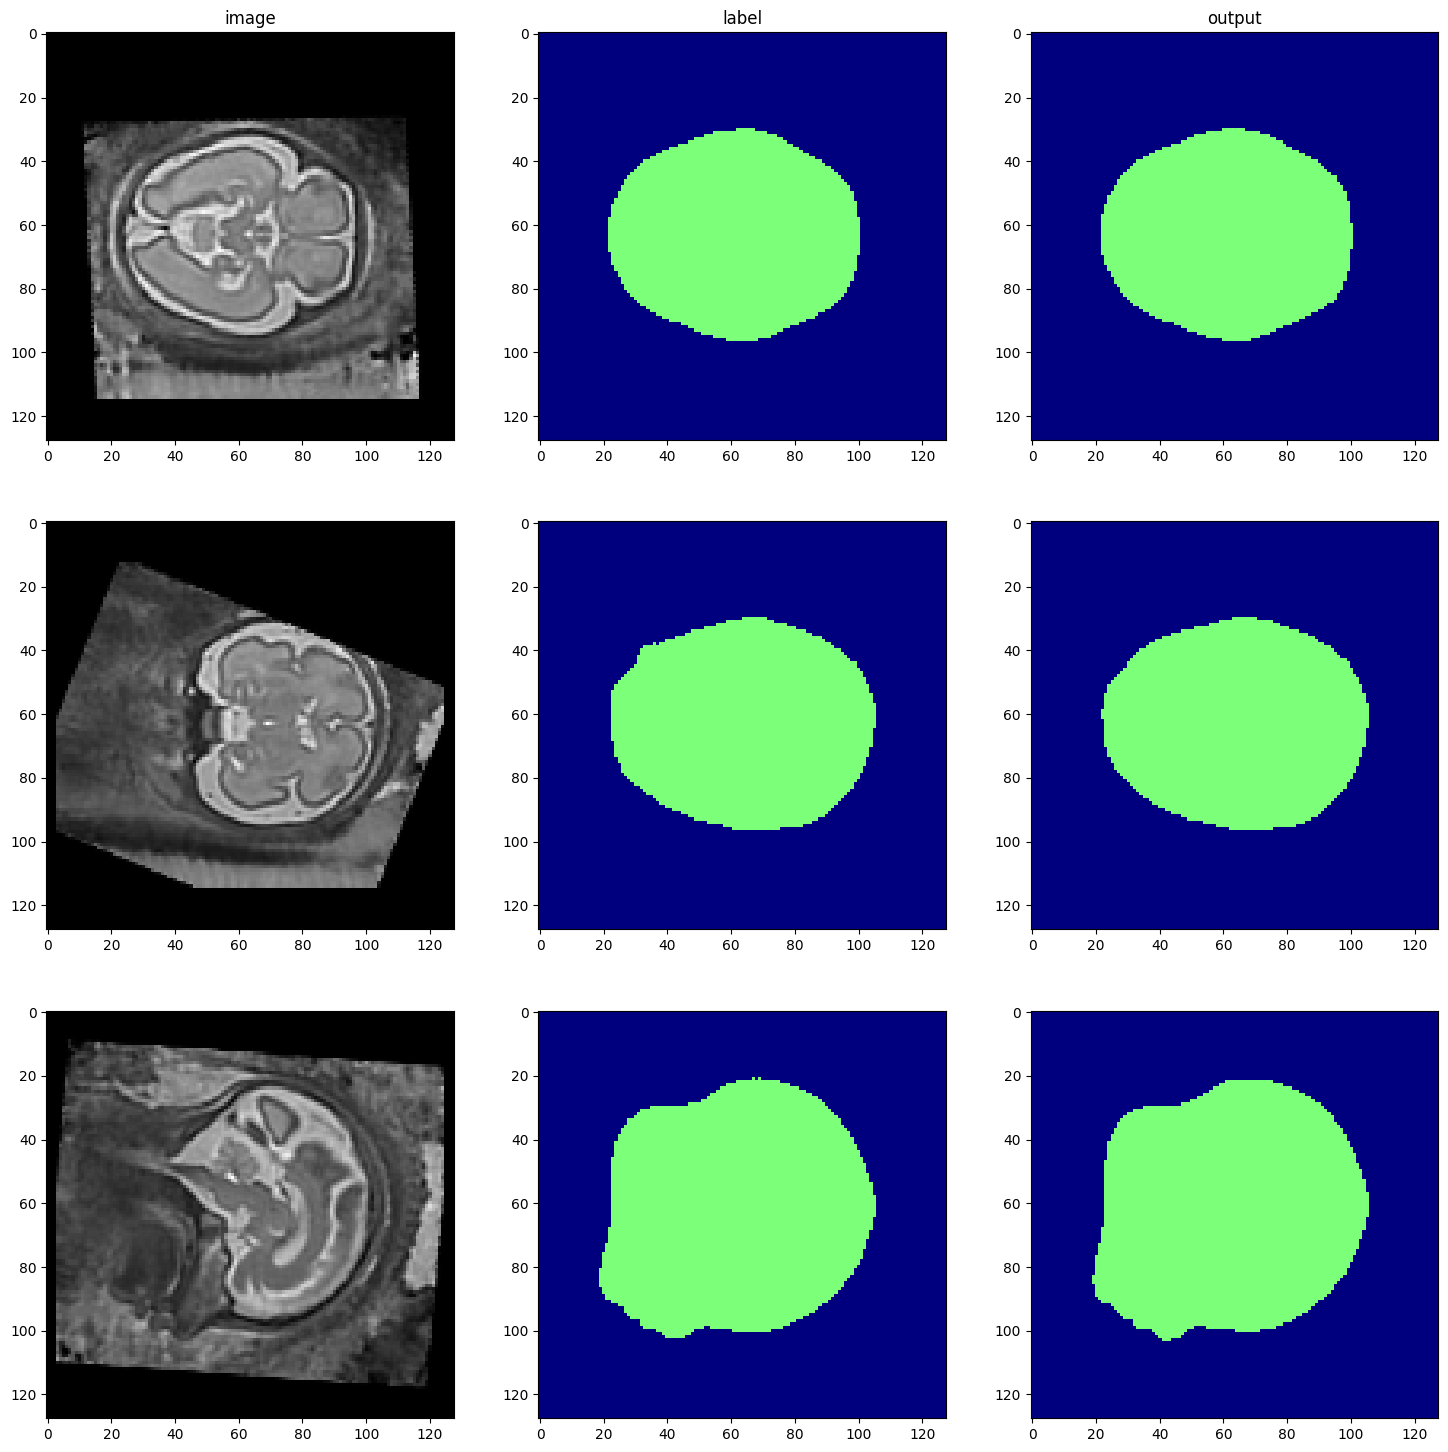

5 hist-136-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


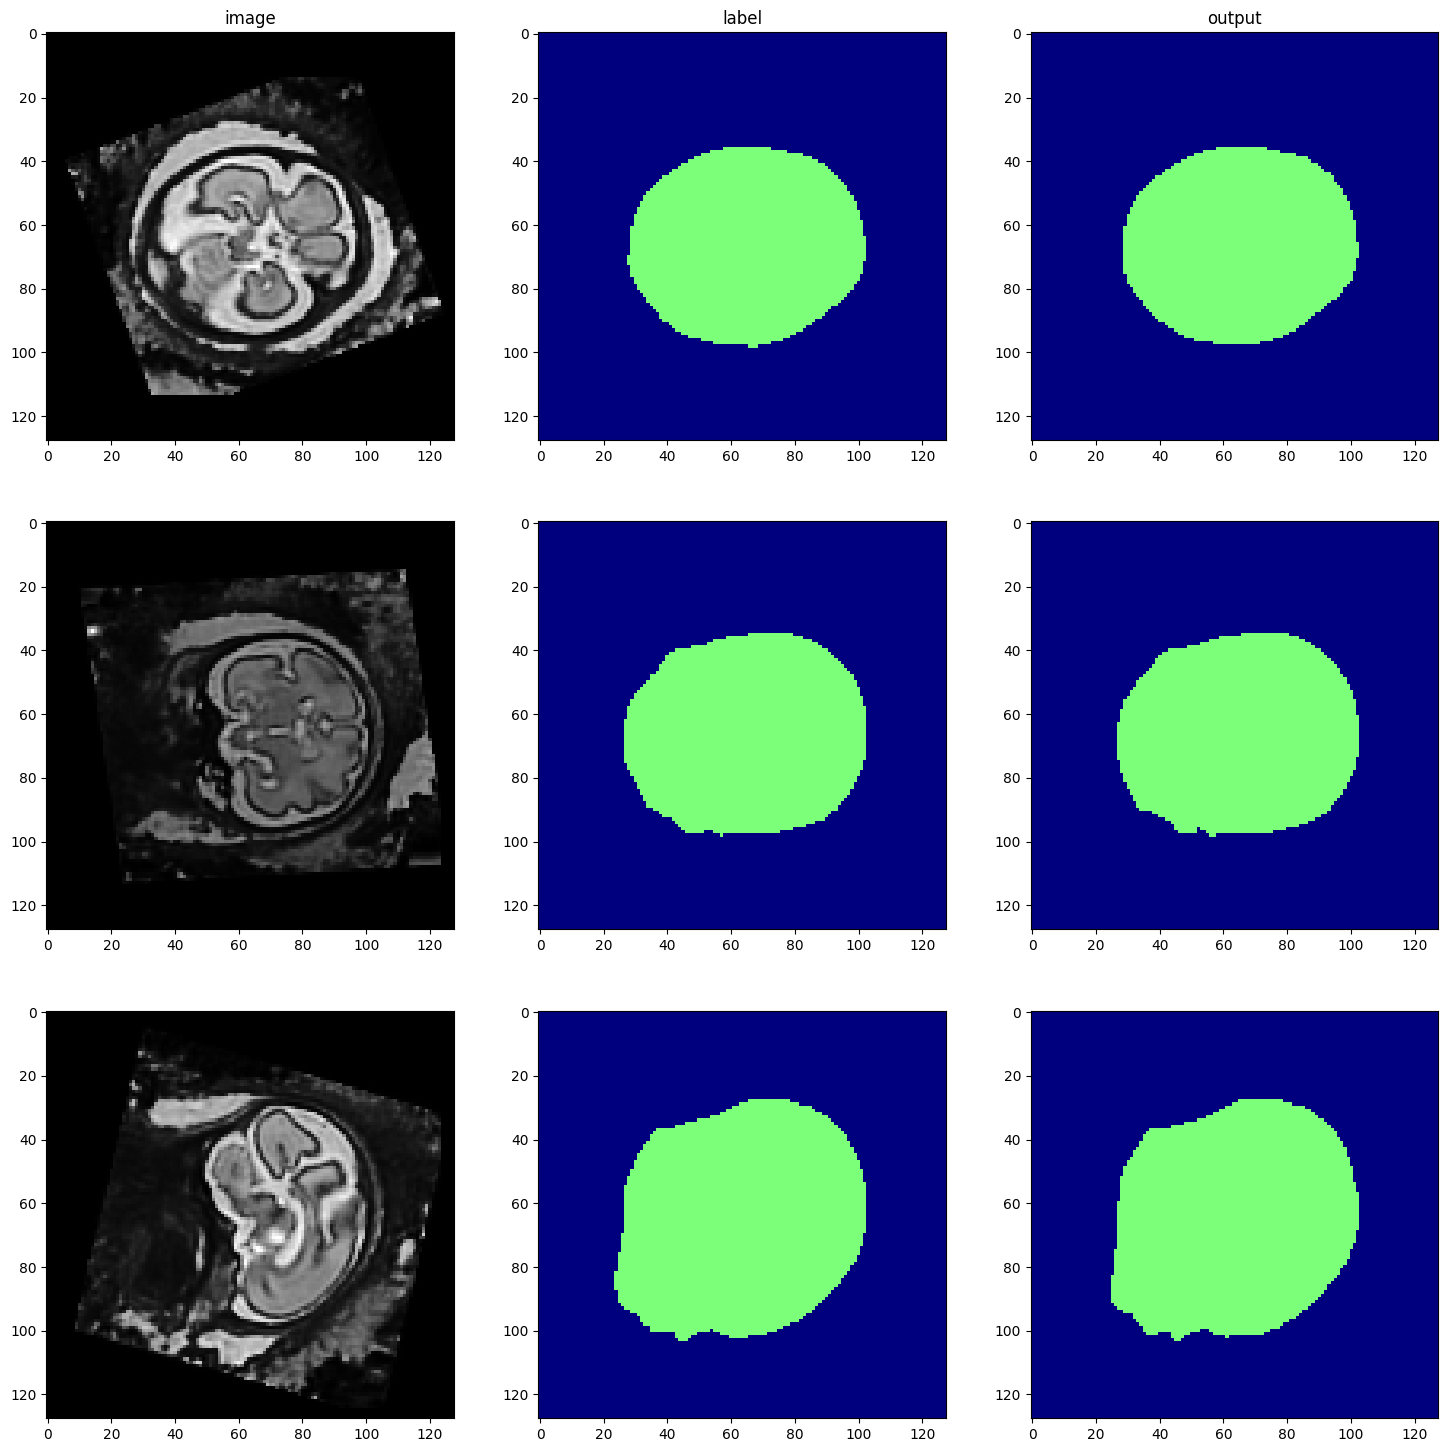

6 hist-214-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


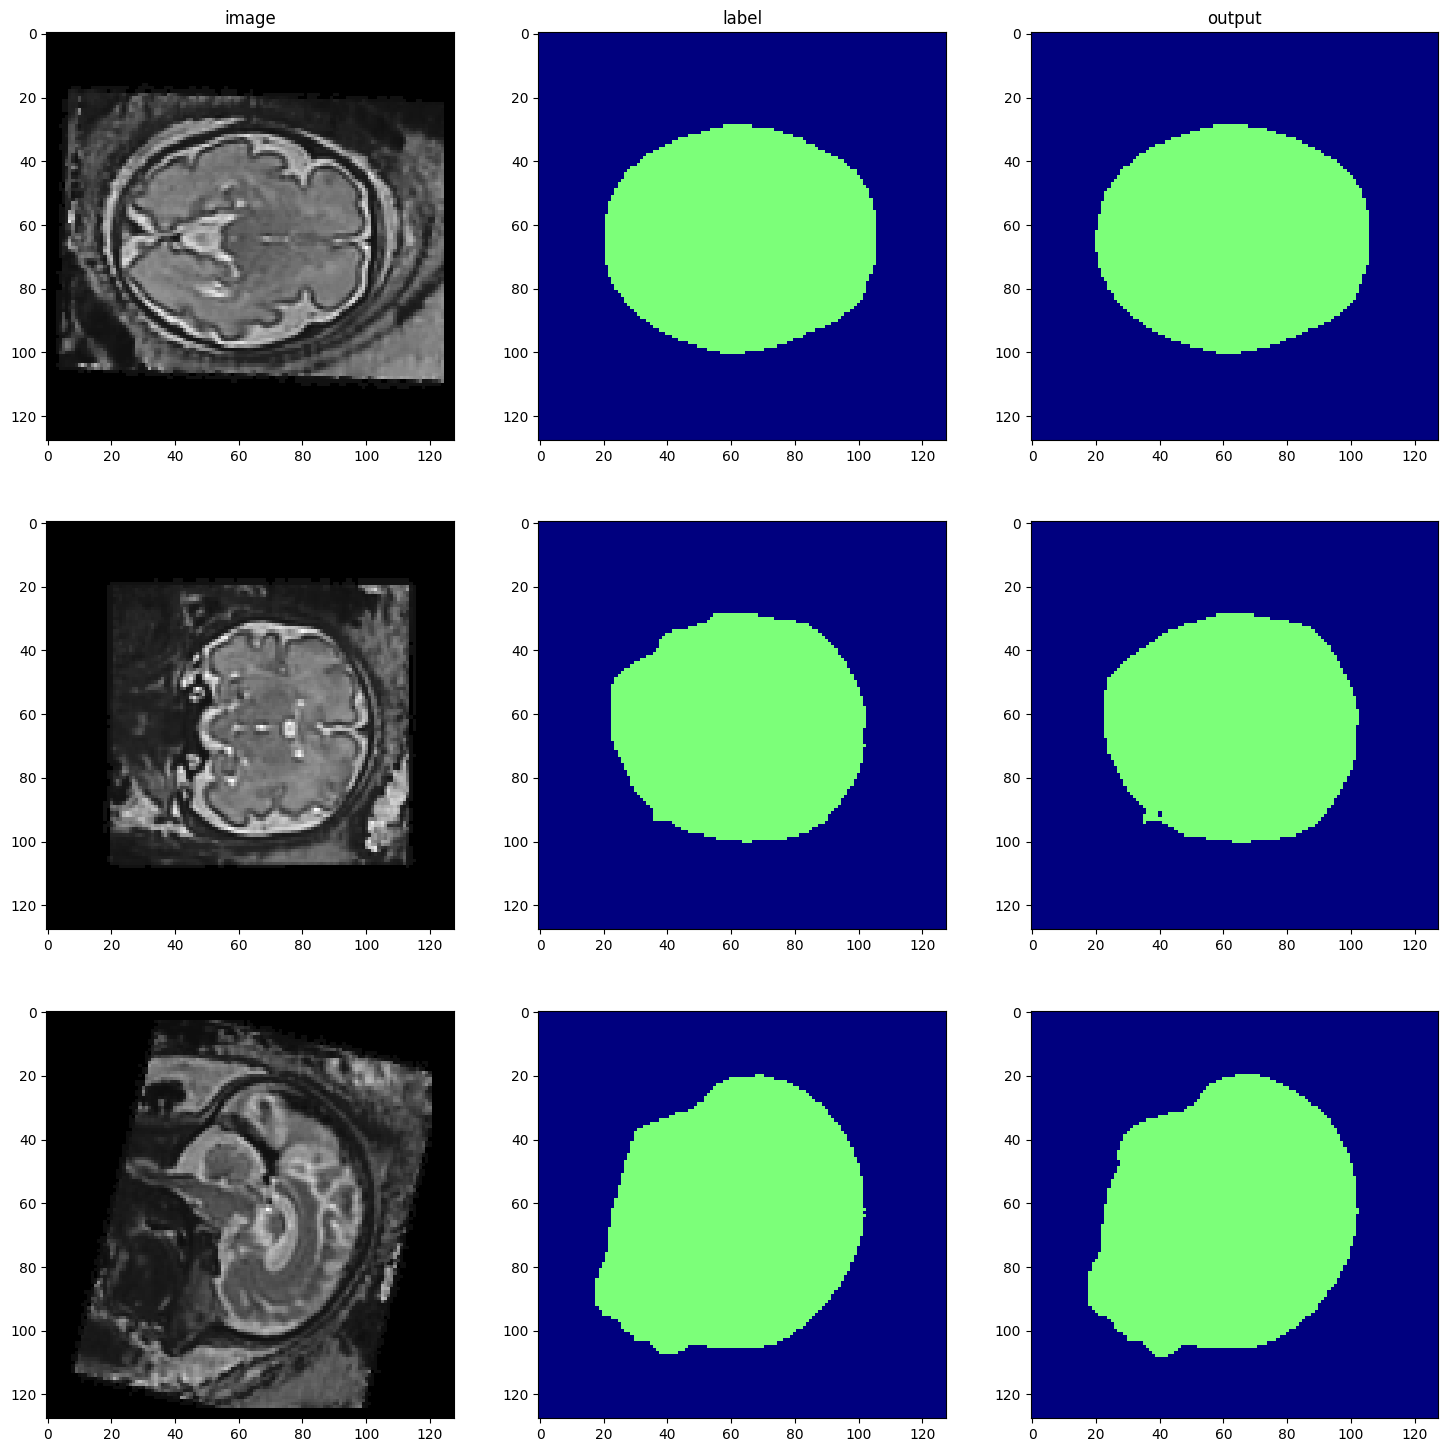

7 hist-236-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


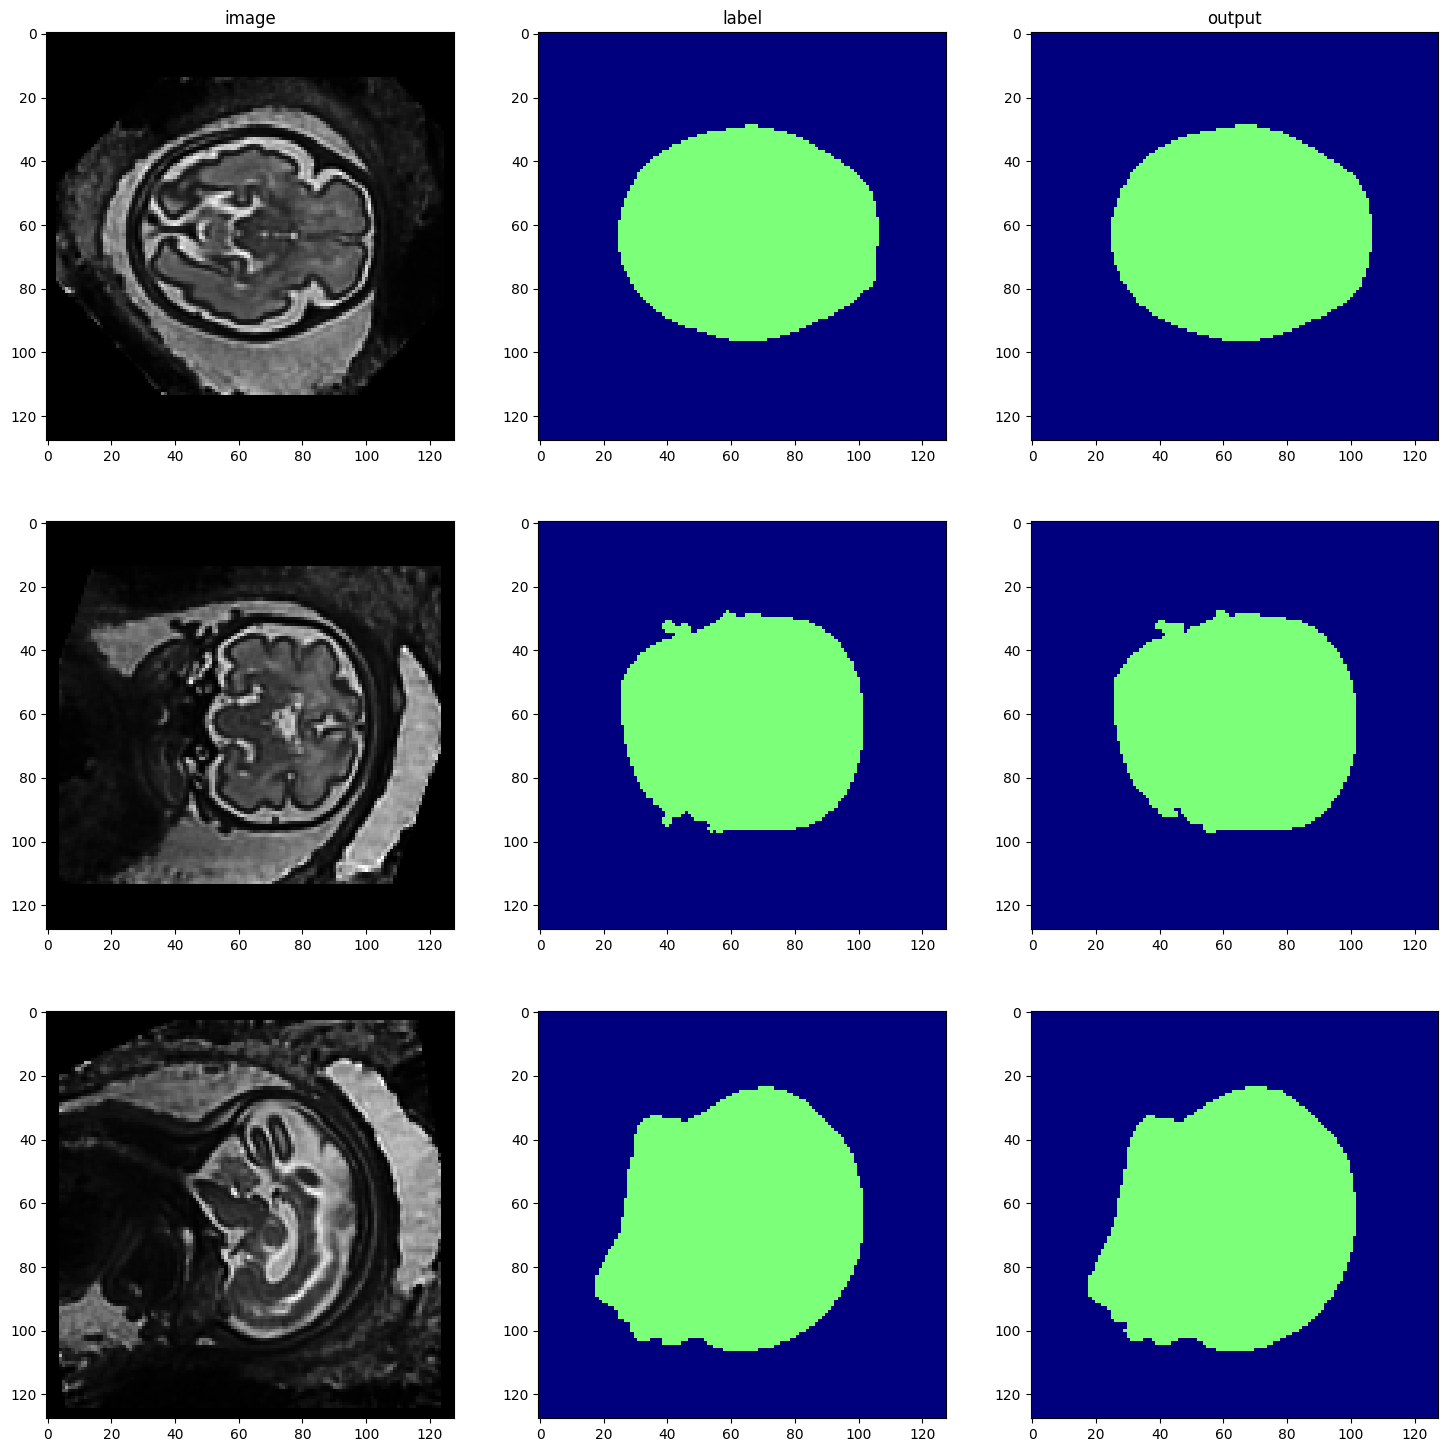

8 hist-253-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


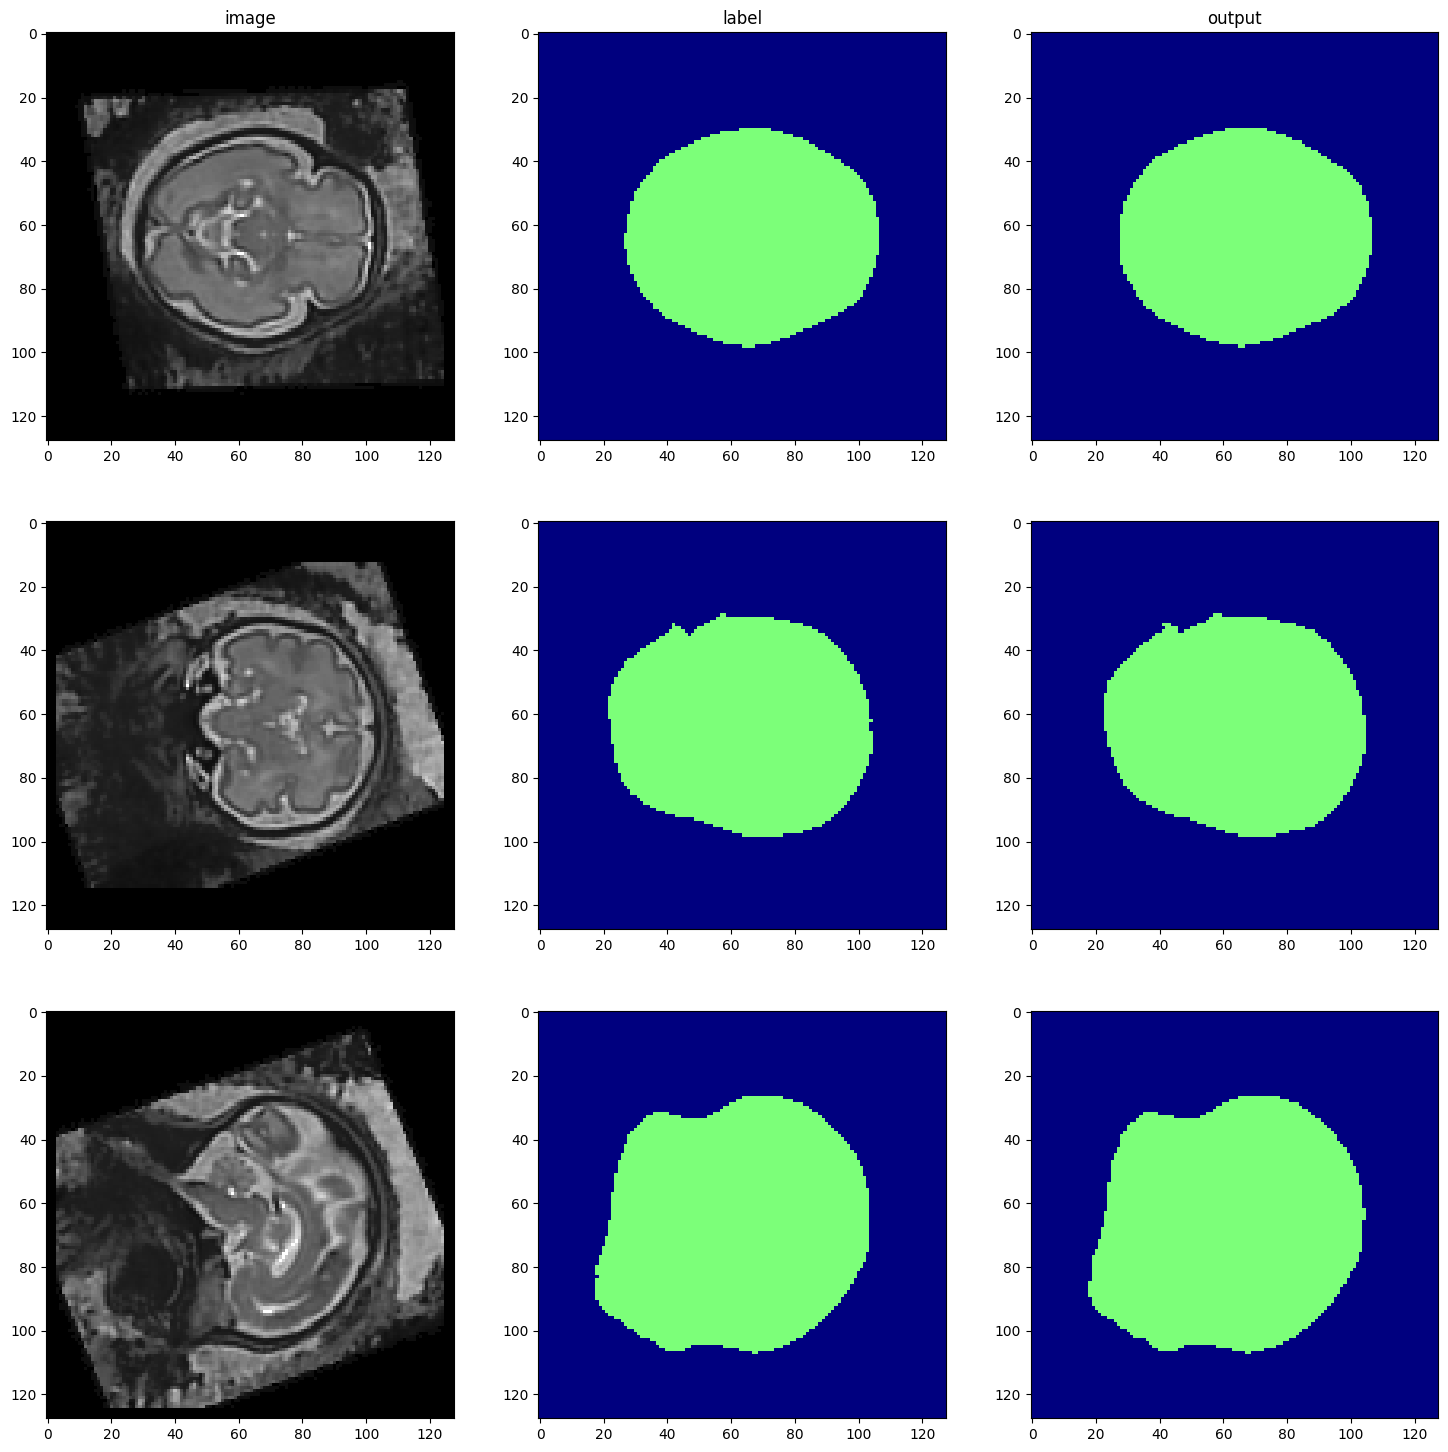

9 hist-275-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


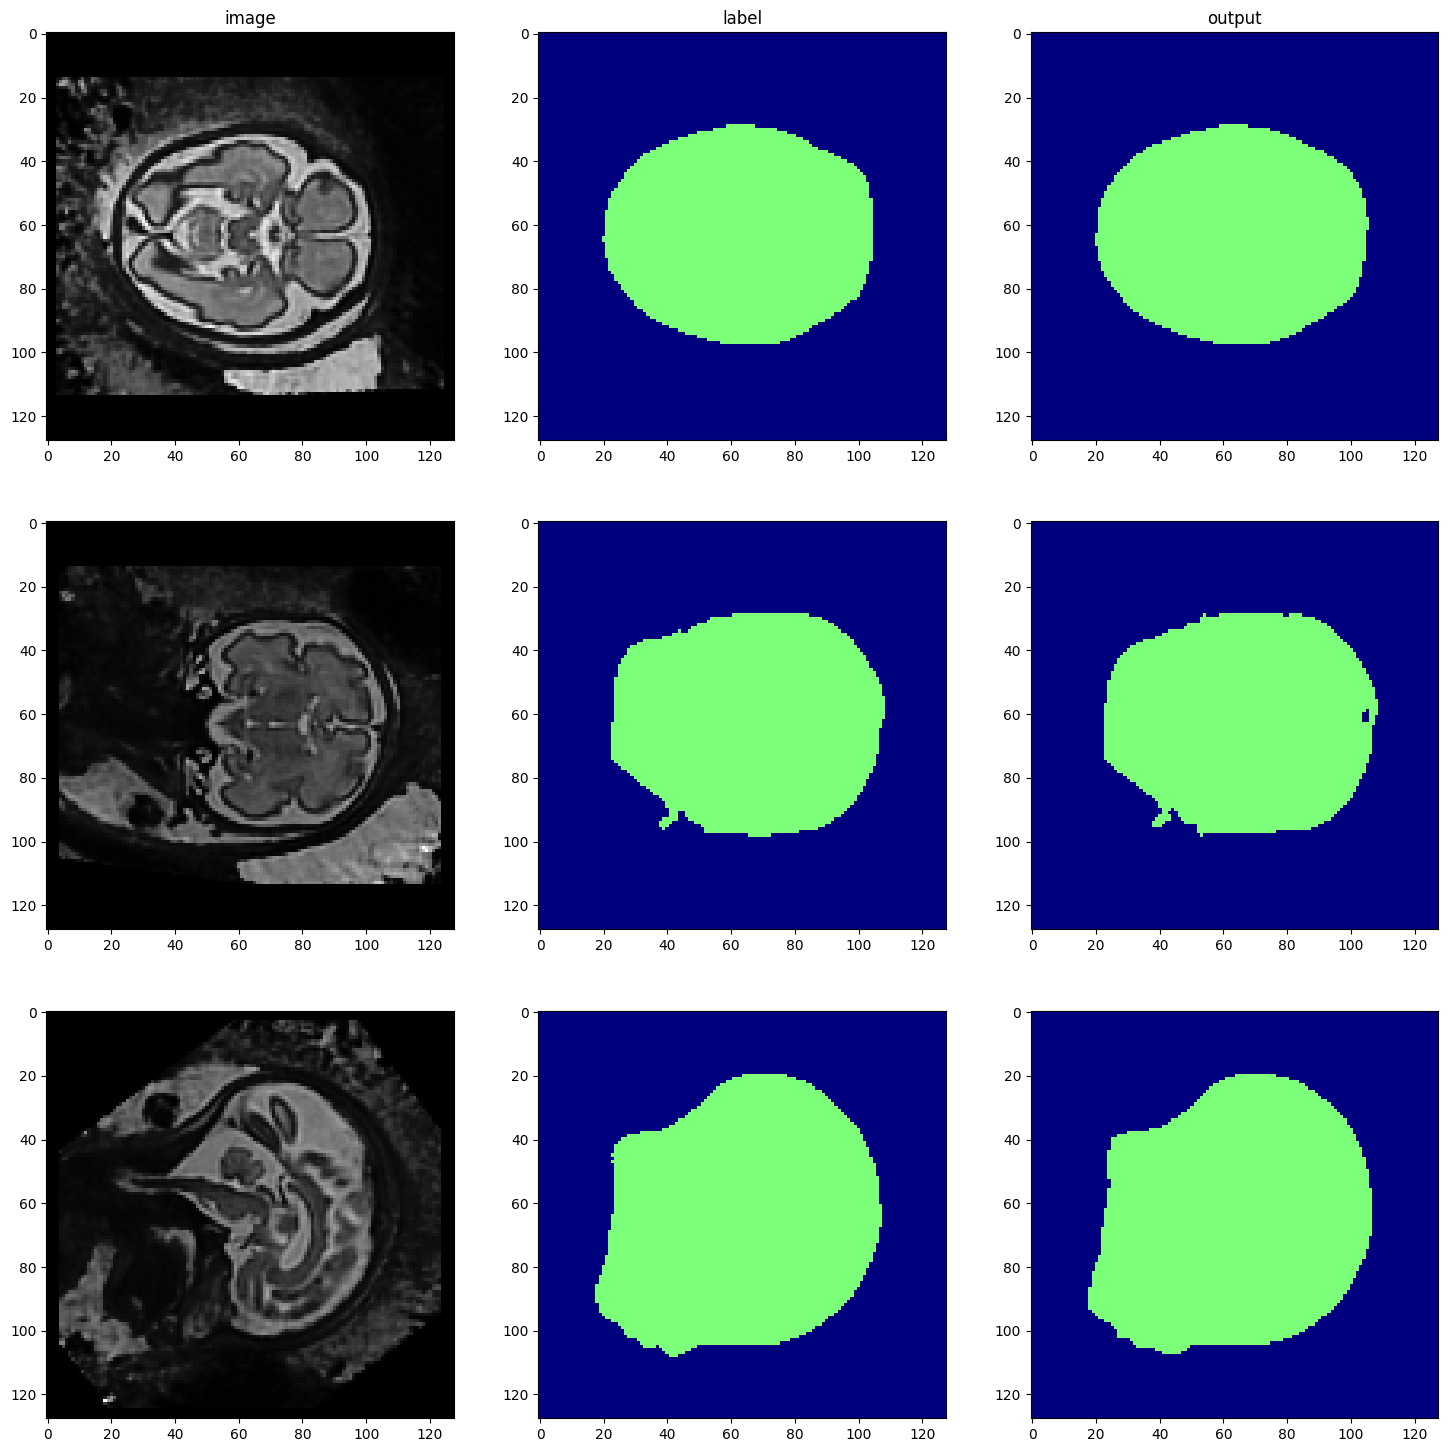

10 hist-292-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


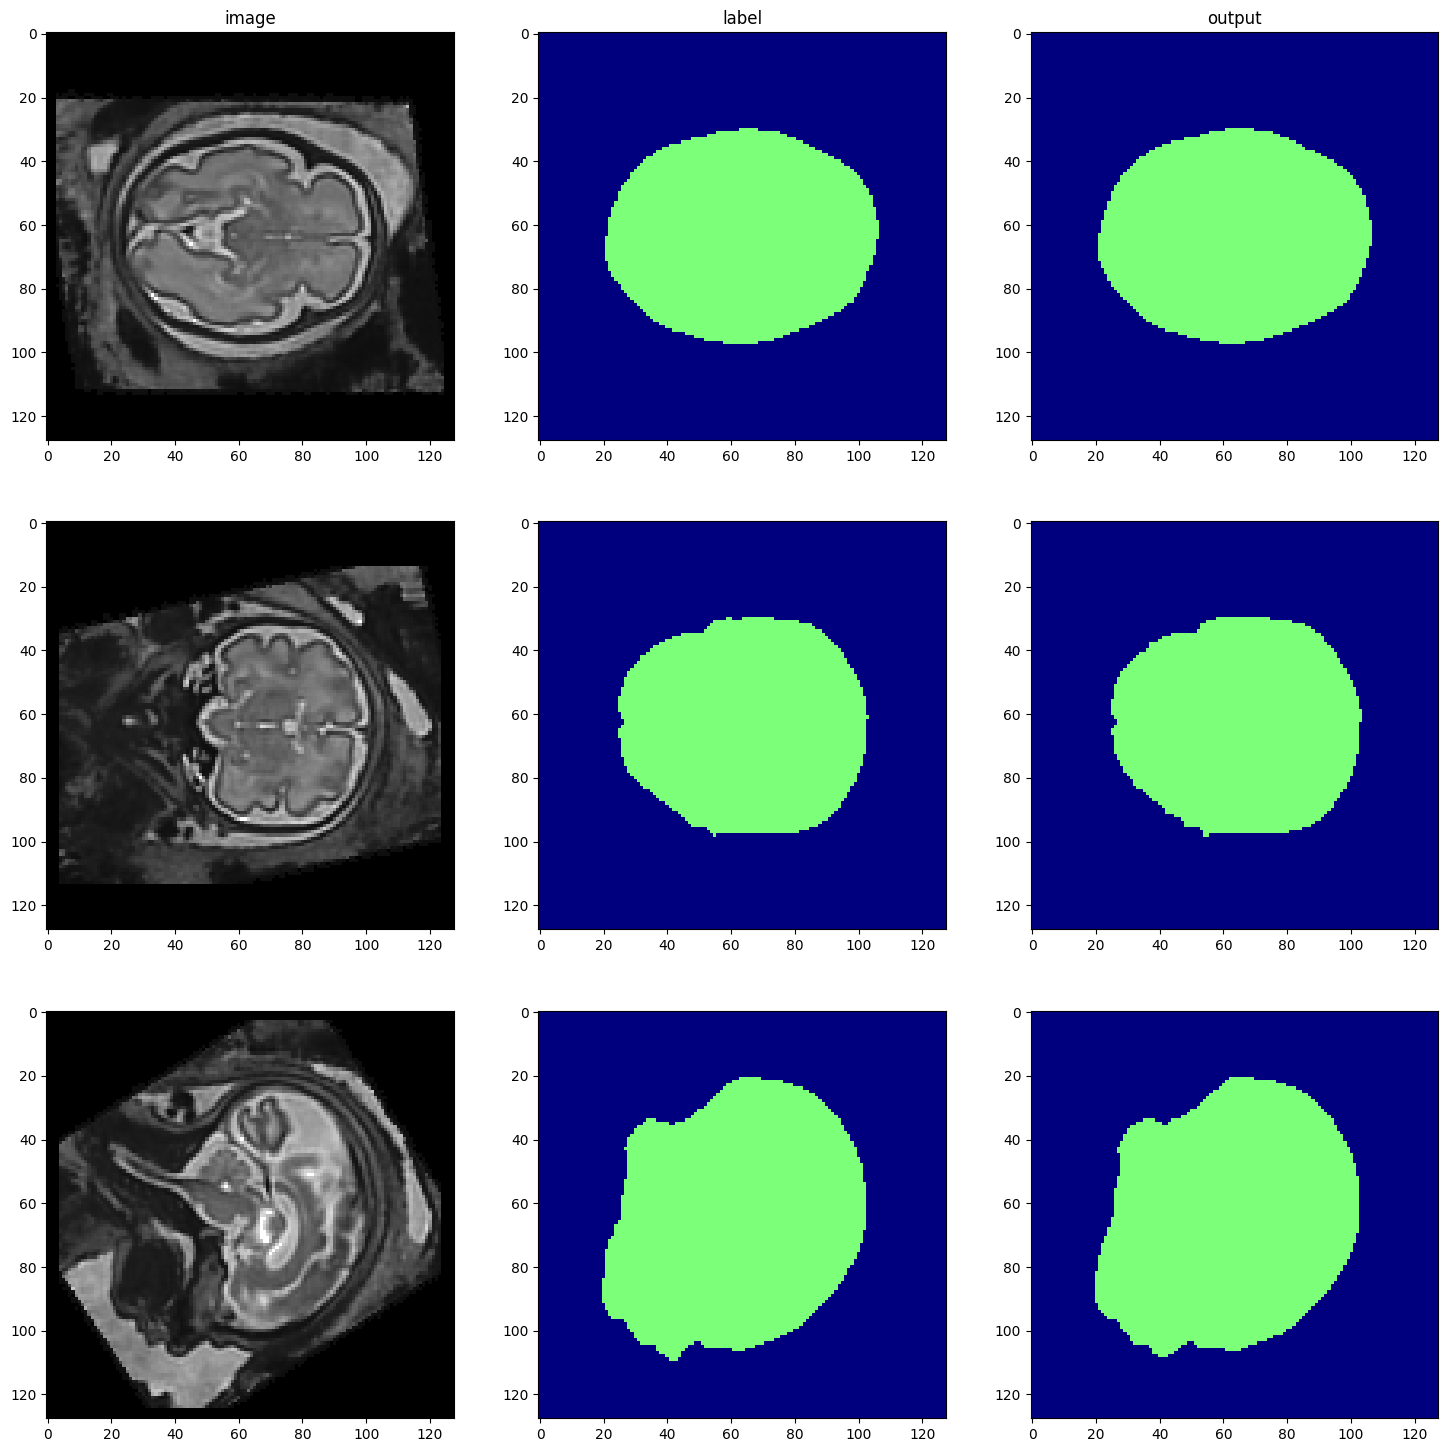

11 hist-355-img.nii.gz
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


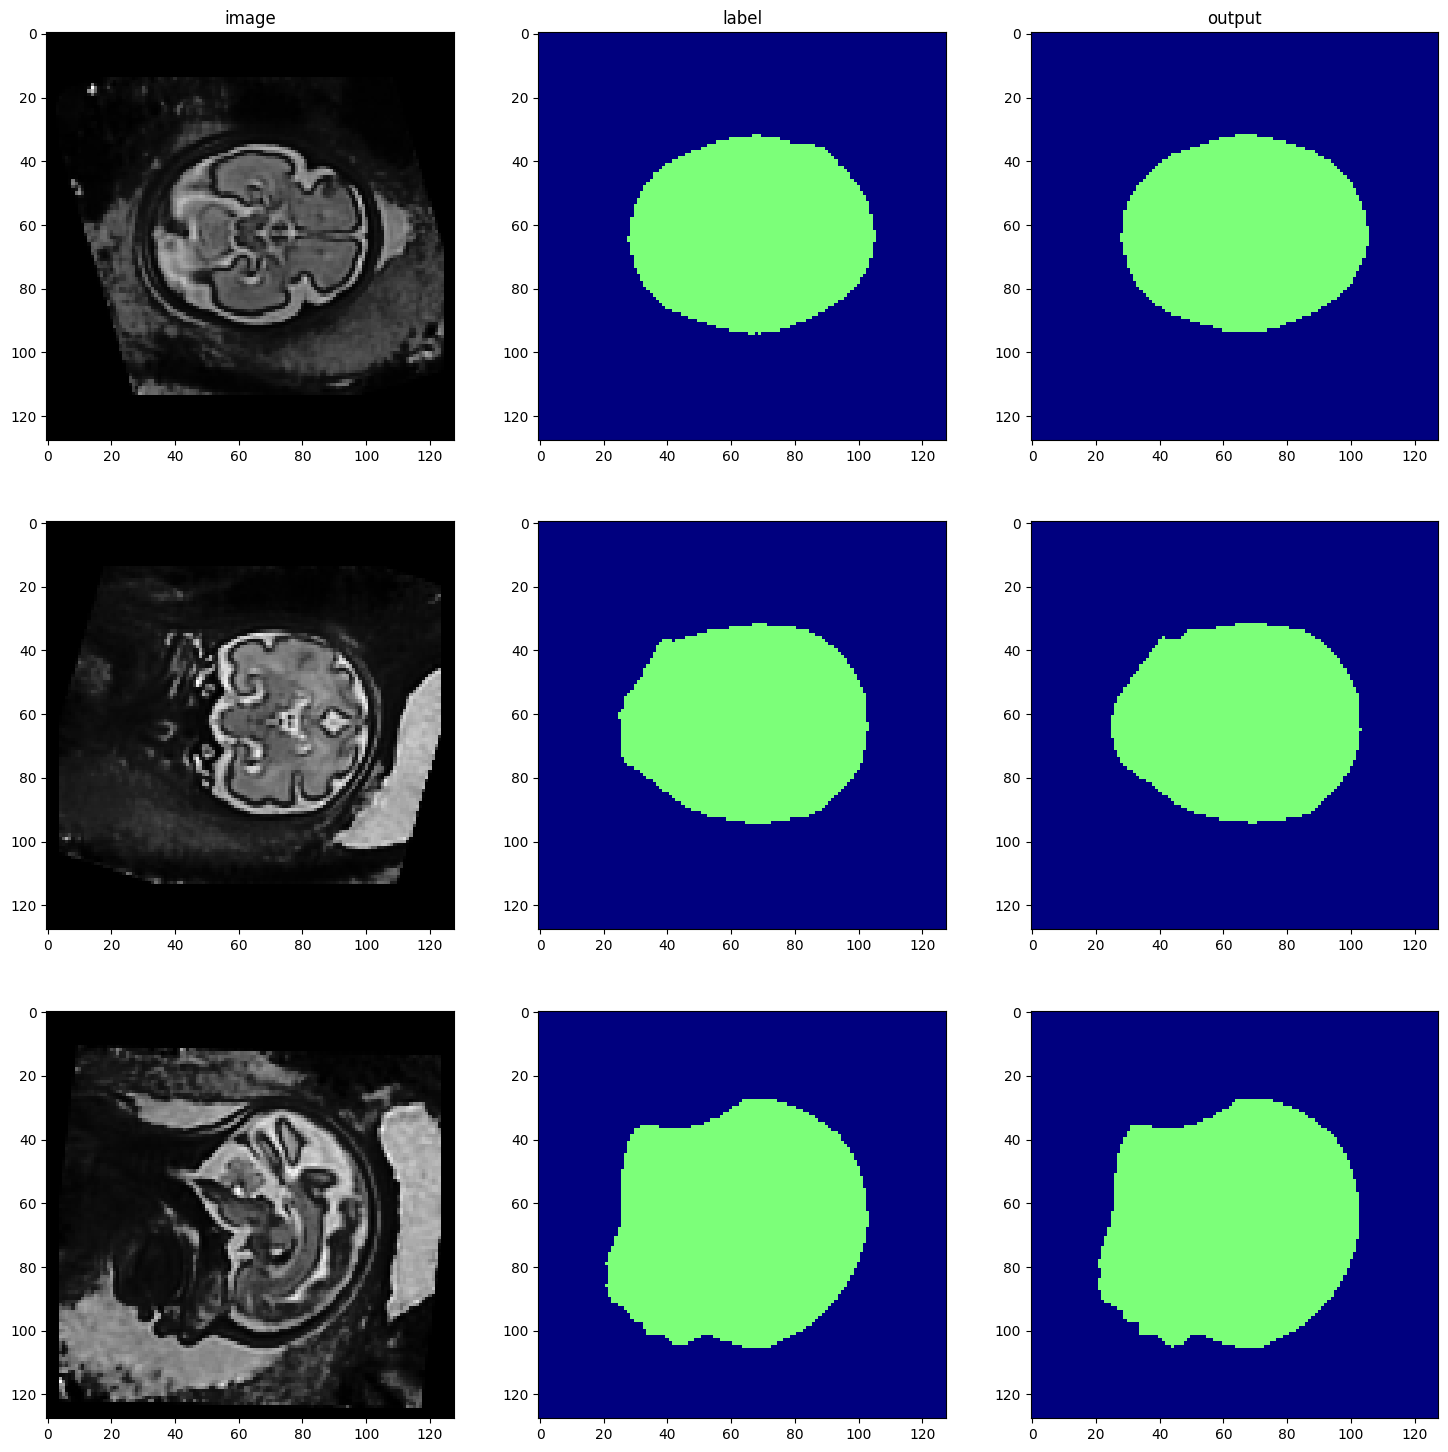

In [ ]:
class_n = class_num
qq=round(img_dim/2)

for x in range(len(val_files_run)):

  case_num = x
  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      cur_case = val_ds_run[case_num]
      img = cur_case["image"]
      label = cur_case["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      print(x,img_name)
      print(val_outputs.shape)
      print(val_labels.shape)

      plt.figure("check", (18, 18))
      plt.subplot(3, 3, 1)
      plt.title("image")
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
      plt.subplot(3, 3, 2)
      plt.title("label")
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 3)
      plt.title("output")
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")

      plt.subplot(3, 3, 4)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
      plt.subplot(3, 3, 5)
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 6)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")


      plt.subplot(3, 3, 7)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
      plt.subplot(3, 3, 8)
      plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 9)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")

      plt.show()

In [ ]:
# save cnn segmentation results for all validation images


res_dir = root_dir + "/" + roi_type + "segresnet-noaug-results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


for x in range(len(val_files_run)):

  case_num = x
  img_name = val_files_run[case_num]["label"]
  label_name = val_files_run[case_num]["label"]
  case_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds_run[case_num]["image"]
      label = val_ds_run[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet-noaug-results/cnn-lab-261-img.nii.gz
1 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet-noaug-results/cnn-lab-335-img.nii.gz
2 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet-noaug-results/cnn-lab-426-img.nii.gz
3 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet-noaug-results/cnn-lab-342-img.nii.gz
4 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet-noaug-results/cnn-lab-435-img.nii.gz
5 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet-noaug-results/cnn-lab-hist-136-img.nii.gz
6 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet-noaug-results/cnn-lab-hist-214-img.nii.gz
7 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_segresnet-noaug-results/cnn-lab-hist-236-img.nii.gz
8 /content/drive/MyDrive/